# System Identification in Frequency Domain

In [ ]:
import os
import pywt
import itertools
from itertools import zip_longest
import numpy as np
from numpy.linalg import norm
import math
import pandas as pd
import bamboolib # gui for pandas df
from scipy.fftpack import fft
from scipy.signal import welch
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.tsa.api import VAR
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.io import loadmat
import seaborn as sns
from math import floor
import tkinter as tk
import decimal
from random import shuffle

# Loading The Dataset (Trial by Trial)

In [2]:
# Get the participant data from Dataset directory
t0=0
fs=1200
dt=1.0/fs
num_eeg_ch = 14
num_emg_ch = 4
num_force_ch = 3
num_ch = num_eeg_ch + num_emg_ch + num_force_ch
num_conds = 18
file = loadmat('YZ1200Hz.mat')
columns=['EEG-1','EEG-2','EEG-3','EEG-4','EEG-5',
         'EEG-6','EEG-7','EEG-8','EEG-9','EEG-10',
         'EEG-11','EEG-12','EEG-13','EEG-14','EMG-1',
         'EMG-2','EMG-3','EMG-4','Force-x', 
         'Force-y','Force-z']

In [3]:
data_splitBy_trials = [] # list of data frames, each df corresponding to a trial

for cond in tqdm_notebook(range(num_conds), ascii=True):
    num_trials = file['EEGSeg_Ch'][0,0][0,cond].shape[0]
    # if a trial has long enough samples
    if file['EEGSeg_Ch'][0,0][0,cond].shape[1] >= 400:
        for trial in (range(num_trials)): 
            data = pd.DataFrame(columns=columns)
            for ch in range(num_eeg_ch):
                data.iloc[:,ch] = file['EEGSeg_Ch'][0,ch][0,cond][trial,:]
            for ch in range(num_emg_ch):
                data.iloc[:,ch+num_eeg_ch] = file['EMGSeg_Ch'][0,ch][0,cond][trial,:]
            for ch in range(num_force_ch):
                data.iloc[:,ch+num_eeg_ch+num_emg_ch] = file['ForceSeg_Ch'][0,ch][0,cond][trial,:]

            # mean subtraction in each trial from the eeg and emg columns for removing dc drift
            data.iloc[:,:18] -= data.iloc[:,:18].mean()
            # convert volts to microvolts for EEG and EMG channels
            data.iloc[:,:18] *= 1e6
            # convert volts to milivolts for force channels
            data.iloc[:,18:] *= 1e3  
            data_splitBy_trials.append(data)
       
print('Total number of trials of all the conditions in the file: %i' %len(data_splitBy_trials)) 
data_splitBy_trials[0].head(10) # first 10 samples of the first trial


Total number of trials of all the conditions in the file: 2218


,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-6,EEG-7,EEG-8,EEG-9,EEG-10,...,EEG-12,EEG-13,EEG-14,EMG-1,EMG-2,EMG-3,EMG-4,Force-x,Force-y,Force-z
0,7.026848,2.545901,8.018445,8.515070,7.722273,4.277862,4.848591,4.053847,8.932686,12.119530,...,3.288683,7.441162,7.420796,1.005493,-0.984374,-0.492543,-0.661567,-465.678781,-469.053894,-209.285438
1,7.630511,2.930268,8.330692,9.559325,8.992390,5.481705,6.277512,5.401635,9.845701,13.658078,...,4.812069,7.953348,8.946398,-0.444111,-0.061550,-0.530204,0.982479,-465.621978,-469.136149,-209.314764
2,7.907214,2.956566,8.482912,10.387089,10.045311,6.469230,7.458542,6.447359,10.408324,14.870087,...,6.051306,8.160012,10.184095,-0.139583,-0.191295,0.247625,0.808962,-465.820312,-469.179332,-209.178716
3,7.861338,2.651317,8.480590,10.975818,10.837416,7.203001,8.349306,7.156559,10.585556,15.679061,...,6.956631,8.083563,11.068013,0.302388,-0.571595,1.728487,-0.240347,-466.191292,-469.157100,-208.735332
4,7.521612,2.063324,8.337604,11.313934,11.341879,7.662946,8.926272,7.517504,10.367269,16.036577,...,7.500617,7.763110,11.558172,0.262122,-0.422903,-0.410063,0.806314,-466.624498,-469.041169,-208.153188
5,6.939421,1.259971,8.076539,11.403102,11.552022,7.849187,9.187633,7.543250,9.771637,15.928198,...,7.682024,7.251991,11.645549,0.307539,0.635661,0.889714,-1.051587,-467.069775,-468.935102,-207.573399
6,6.185044,0.322086,7.728282,11.259558,11.483011,7.783061,9.154282,7.271528,8.845711,15.376274,...,7.527216,6.614170,11.354148,0.041239,1.319572,0.181327,-0.605513,-467.461199,-468.901575,-206.810668
7,5.342099,-0.662421,7.330909,10.914134,11.171604,7.506173,8.868812,6.762322,7.663284,14.439179,...,7.089009,5.919787,10.739832,-1.441106,1.140962,0.743729,2.234643,-467.728317,-468.937397,-206.108674
8,4.500588,-1.605709,6.927795,10.410652,10.673661,7.077373,8.392187,6.093035,6.319789,13.206831,...,6.442813,5.239998,9.885670,-1.370035,0.791192,0.486277,0.040418,-467.965633,-469.034940,-205.684155
9,3.749578,-2.426571,6.565255,9.803436,10.060141,6.568272,7.798980,5.352349,4.924988,11.793276,...,5.680765,4.641941,8.894697,0.003040,1.808313,0.686337,0.555555,-468.160361,-469.126999,-205.285832


In [4]:
trial_id = 0 # choose one trial
num_samples = data_splitBy_trials[trial_id].shape[0]
time = (np.arange(0, num_samples) * dt + t0) * 1e3
# pick one channel from eeg, emg and force
eeg_signal_1 = data_splitBy_trials[0].iloc[:,0] # trial 1, eeg_ch1
emg_signal_1 = data_splitBy_trials[0].iloc[:,14] # trial 1, emg_ch1
force_signal_3 = data_splitBy_trials[0].iloc[:,20] # trial 1, force_ch3

# Visualization of The Dataset

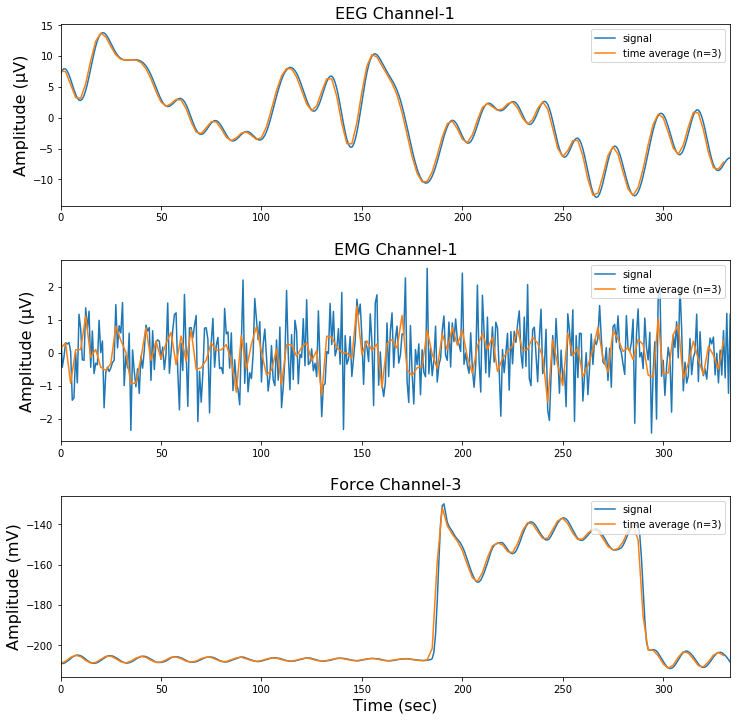

In [5]:
def get_ave_values(xvalues, yvalues, n):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(average_over))
    ax.set_xlim([time[0], time[-1]])
    ax.legend(loc='upper right')

fig, axes = plt.subplots(3, figsize=(12,12))
fig.subplots_adjust(hspace=0.3)
plot_signal_plus_average(axes[0], time, eeg_signal_1, average_over=3)

axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[0].set_title('EEG Channel-1', fontsize=16)
plot_signal_plus_average(axes[1], time, emg_signal_1, average_over=3)

axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('EMG Channel-1', fontsize=16)
plot_signal_plus_average(axes[2], time, force_signal_3, average_over=3)

axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_xlabel('Time (sec)', fontsize=16)
axes[2].set_title('Force Channel-3', fontsize=16)

plt.show()

# Fourier Transform of The Data

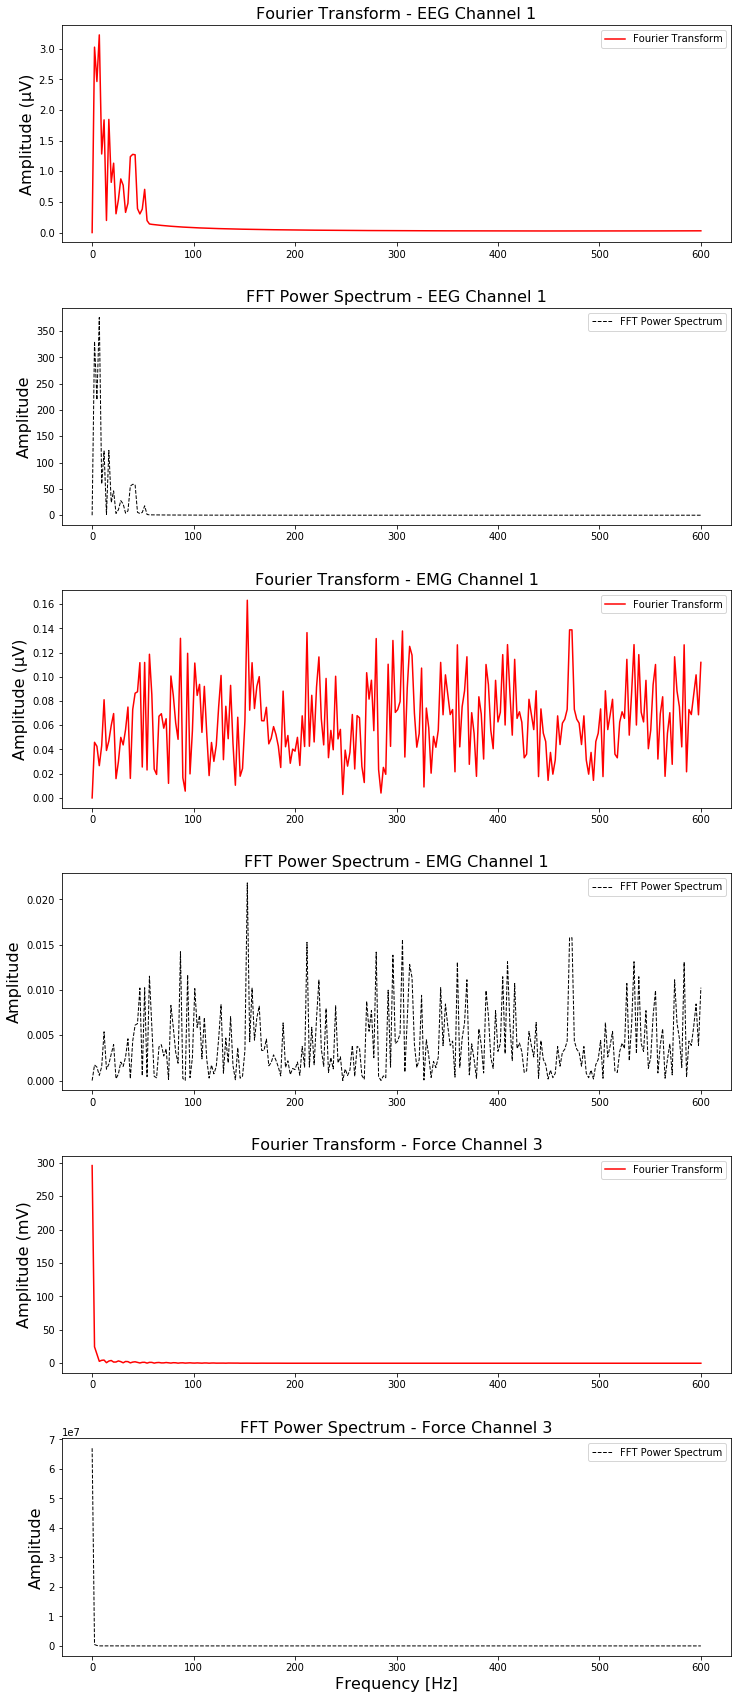

In [6]:
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(axes, time, signal, N, fs=fs, dt=dt,
                        plot_direction='horizontal', yticks=None, ylim=None):
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2

    if plot_direction == 'horizontal':
        axes[0].plot(f_values, fft_values, 'r-', label='Fourier Transform')
        axes[1].plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        axes[0].plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        axes[1].plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        axes[0].set_yticks(np.log2(yticks))
        axes[0].set_yticklabels(yticks)
        axes[0].invert_yaxis()
        axes[0].set_ylim(ylim[0], -1)
    axes[0].legend()
    axes[1].legend()

fig, axes = plt.subplots(6, figsize=(12,30))
fig.subplots_adjust(hspace=0.3)
axes[0].set_title('Fourier Transform - EEG Channel 1', fontsize=16)
axes[1].set_title('FFT Power Spectrum - EEG Channel 1', fontsize=16)
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[0], axes[1]], time, eeg_signal_1, len(eeg_signal_1))

axes[2].set_title('Fourier Transform - EMG Channel 1', fontsize=16)
axes[3].set_title('FFT Power Spectrum - EMG Channel 1', fontsize=16)
axes[2].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[3].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[2], axes[3]], time, emg_signal_1, len(emg_signal_1))

axes[4].set_title('Fourier Transform - Force Channel 3', fontsize=16)
axes[5].set_title('FFT Power Spectrum - Force Channel 3', fontsize=16)
axes[4].set_ylabel('Amplitude (mV)', fontsize=16)
axes[5].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[4], axes[5]], time, force_signal_3, len(force_signal_3))
axes[5].set_xlabel('Frequency [Hz]', fontsize=16)

plt.show()

# Estimation of The Power Spectral Density Using Welch’s Method

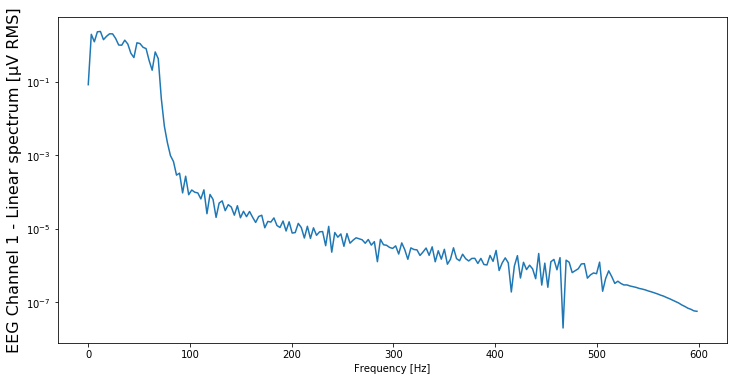

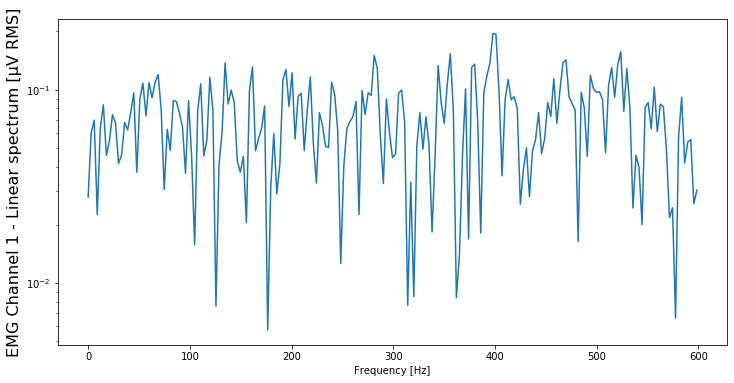

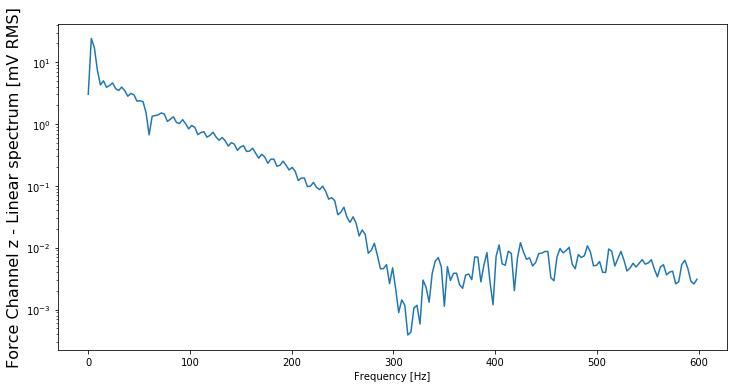

In [7]:
# Welch’s method computes an estimate of the power spectral density by dividing the data
# into overlapping segments, computing a modified periodogram for each segment 
# and averaging the periodograms.

# For the default ‘hanning’ window an overlap of 50% is a reasonable trade off 
# between accurately estimating the signal power, while not over counting any of the data. 
# Narrower windows may require a larger overlap.
for counter, x in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    f, Pxx_spec = welch(x, fs, 'hanning', len(x), scaling='spectrum')
    plt.figure(figsize=(12,6))    
    plt.semilogy(f, np.sqrt(Pxx_spec))
    plt.xlabel('Frequency [Hz]')
    if counter == 0:
        plt.ylabel('EEG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    elif counter == 1:
        plt.ylabel('EMG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    else:
        plt.ylabel('Force Channel z - Linear spectrum [mV RMS]', fontsize=16)
    plt.show()
    
# The peak height in the power spectrum is an estimate of the RMS amplitude.

# Discrete Wavelet Transform Coefficients

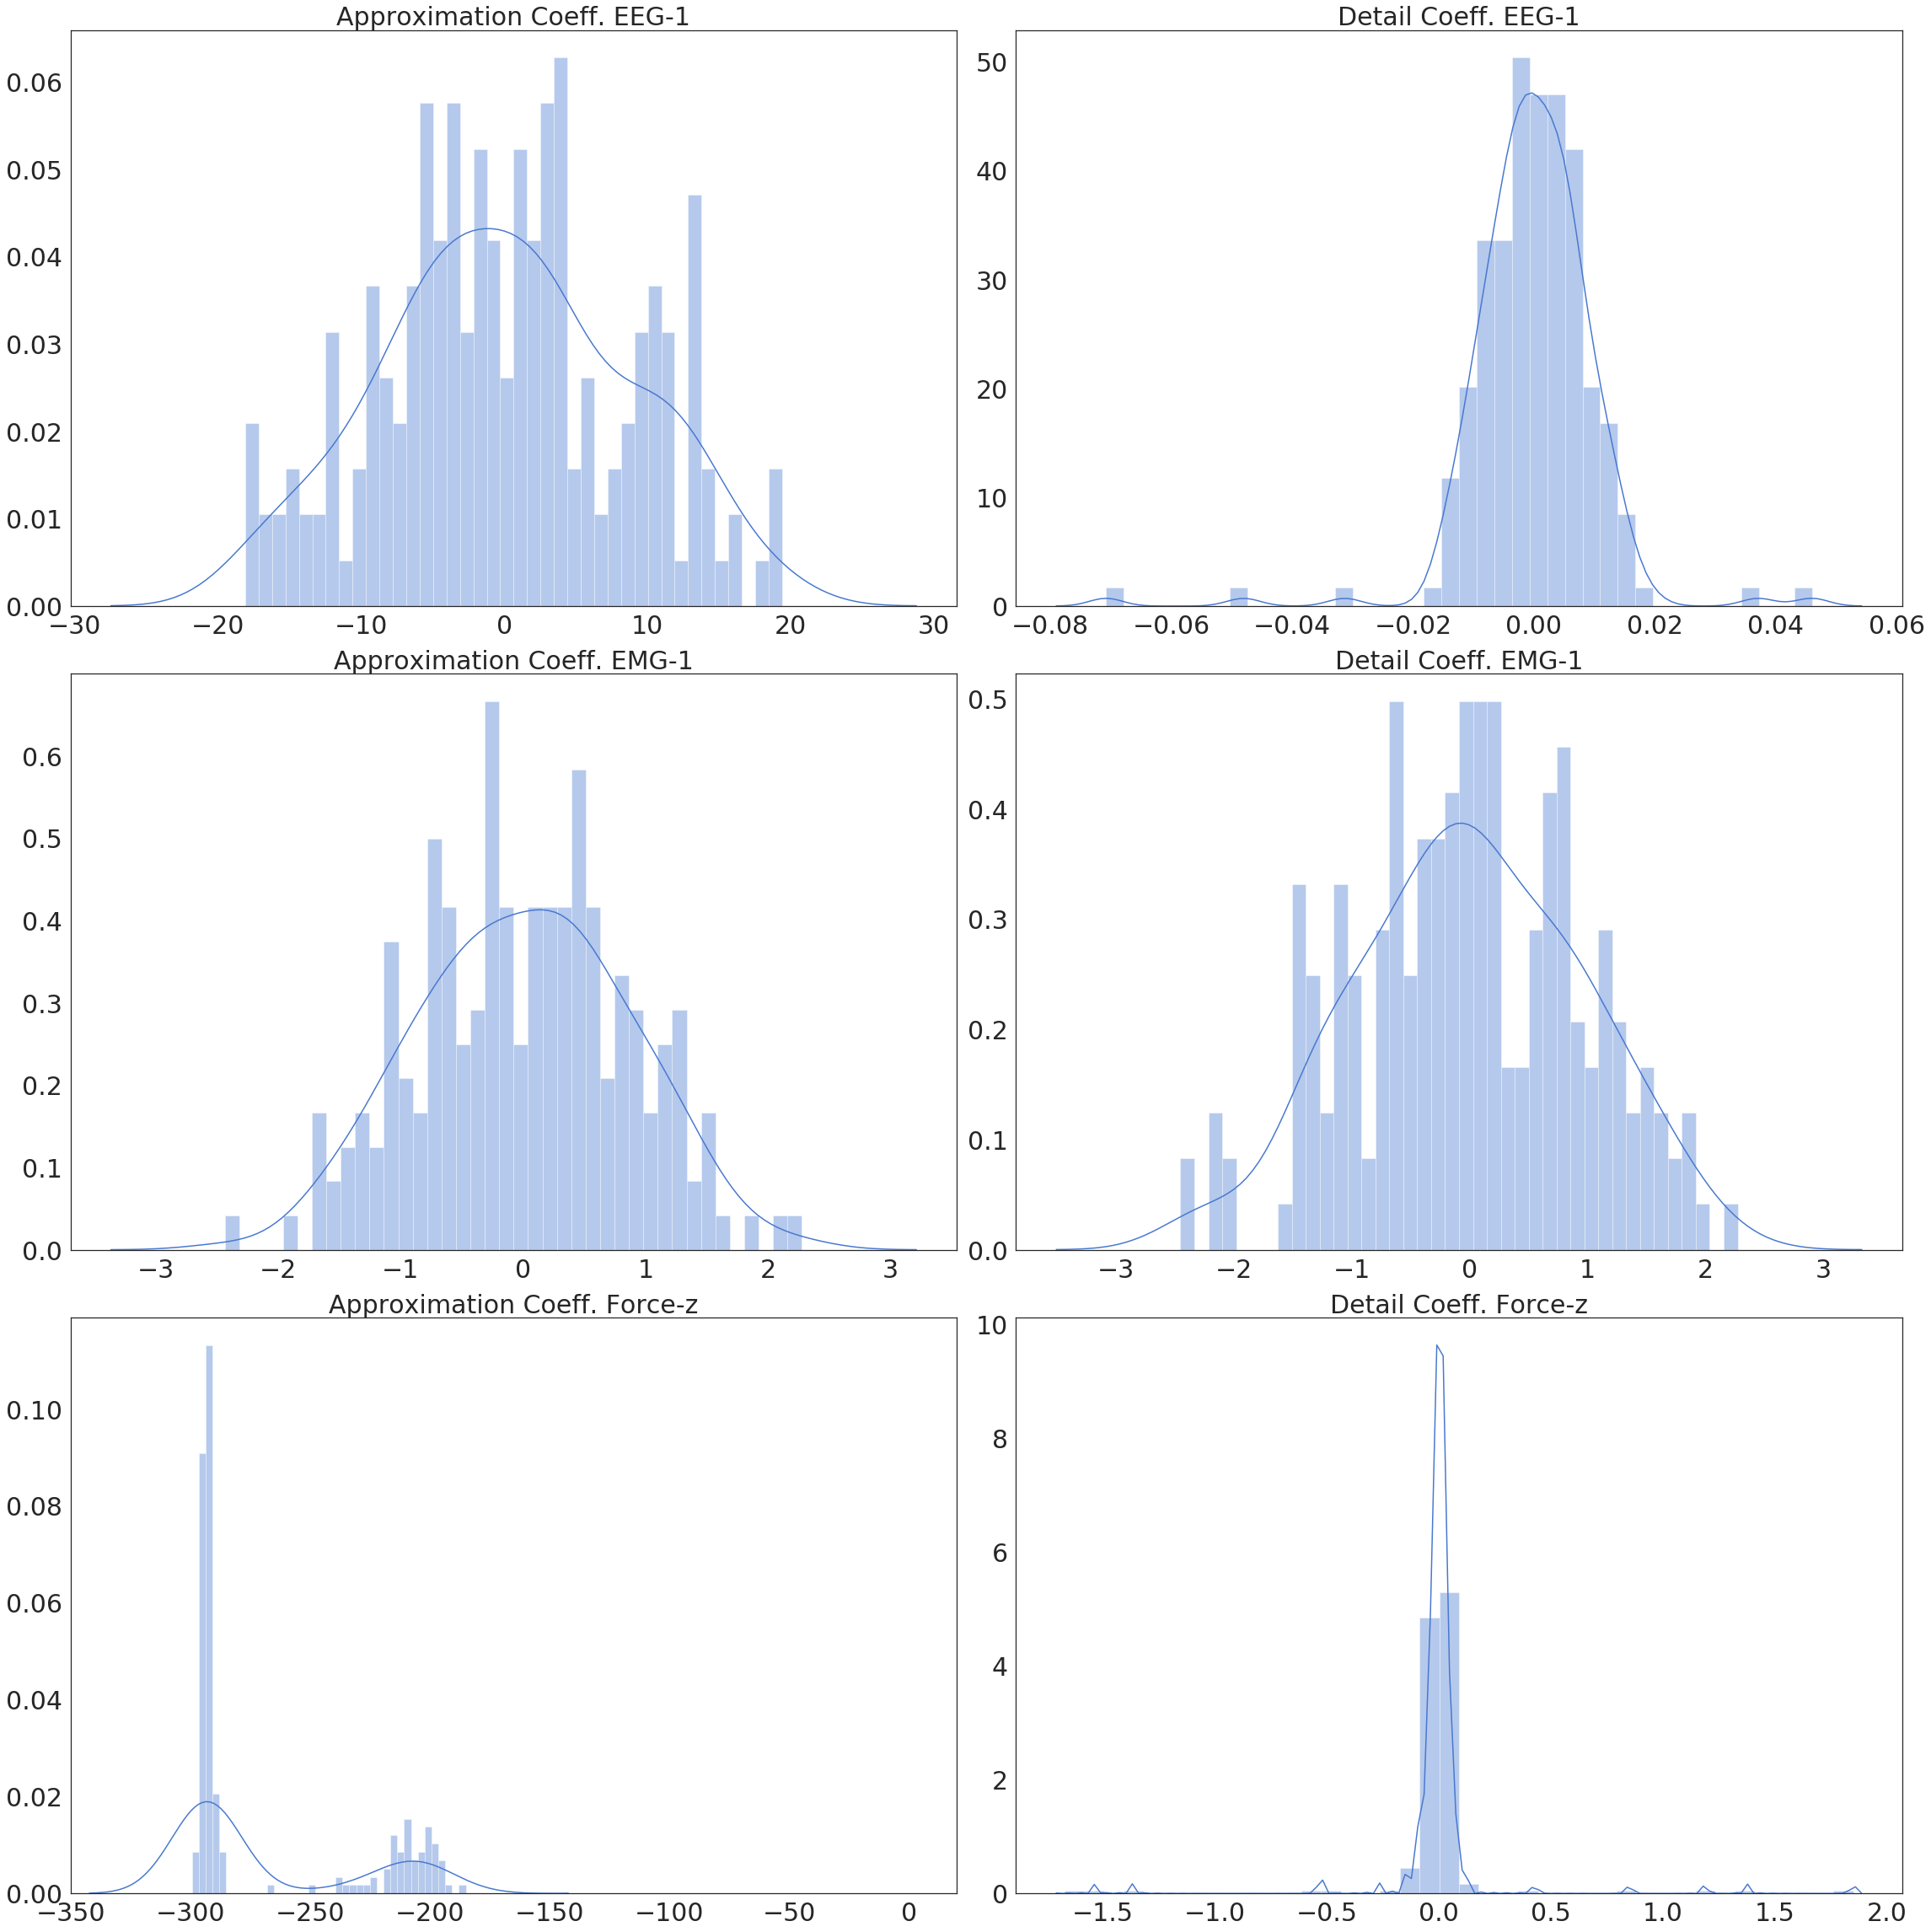

In [8]:
# cA: approximation coefficients (low frquency components)
# cD: detail coefficients (high frequency components)
(cA_eeg1, cD_eeg1) = pywt.dwt(eeg_signal_1, 'db4')
(cA_emg1, cD_emg1) = pywt.dwt(emg_signal_1, 'db4')
(cA_force3, cD_force3) = pywt.dwt(force_signal_3, 'db4')

list_of_coeffs = [cA_eeg1, cD_eeg1, cA_emg1, cD_emg1, cA_force3, cD_force3]

# Plot a histogram and kernel density estimate of wavelet coefficients
def hist_dwtCoeffs(list_of_coeffs):
    sns.set(style="white", palette="muted", color_codes=True)
    fig, axes = plt.subplots(3, 2, figsize=(32,32), sharex=False)
    for i, coeffs in enumerate(list_of_coeffs):
        sns.distplot(coeffs, bins=40, ax=axes[floor(i/2), i%2])
        axes[floor(i/2), i%2].tick_params(axis='both', which='major', labelsize=30)

    axes[0, 0].set_title('Approximation Coeff. EEG-1', fontsize=30) 
    axes[0, 1].set_title('Detail Coeff. EEG-1', fontsize=30)        
    axes[1, 0].set_title('Approximation Coeff. EMG-1', fontsize=30) 
    axes[1, 1].set_title('Detail Coeff. EMG-1', fontsize=30)    
    axes[2, 0].set_title('Approximation Coeff. Force-z', fontsize=30) 
    axes[2, 1].set_title('Detail Coeff. Force-z', fontsize=30)  
    axes[2, 0].set_xlim([-350, 20])

    plt.tight_layout()
    
hist_dwtCoeffs(list_of_coeffs)

Length of approximation and detail coefficients is 3 samples longer than half the length 
of the given signal. If the signal length is odd, half the signal length is rounded up.

# Parsimonity of Transform

### a) Reconstruction Without Compression

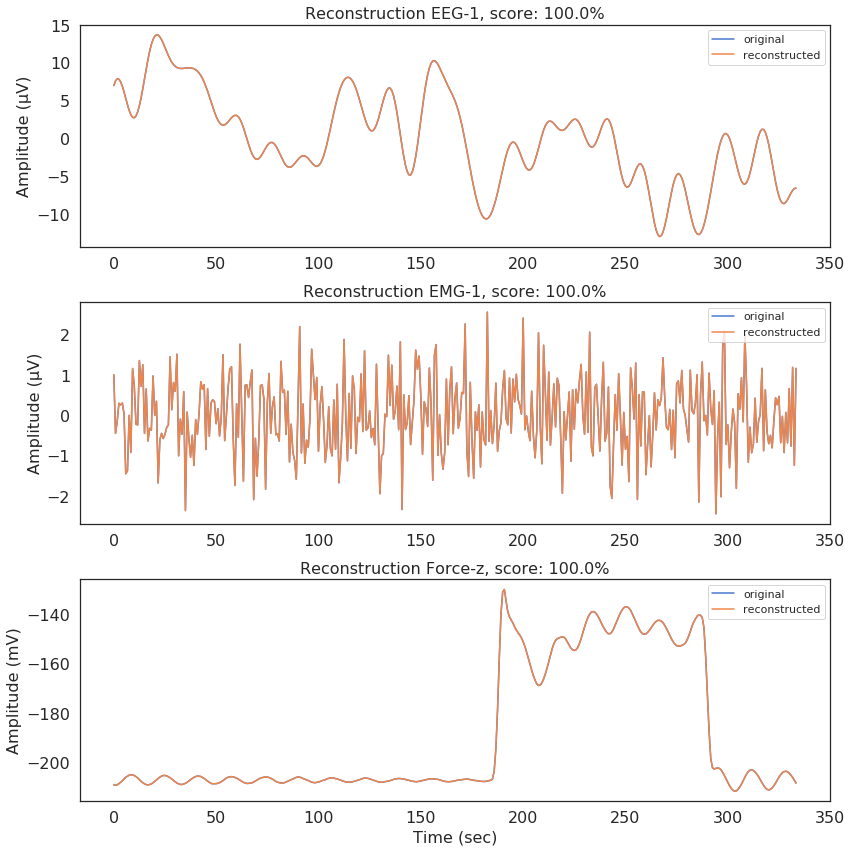

In [9]:
def get_reconstruction_score(original_sig, reconstructed_sig):
    return 100 * (norm(reconstructed_sig) ** 2 / norm(original_sig) ** 2)
    
scores = []
reconstructed_sigs = []
# Plot the reconstructed signals and show reconstruction scores
fig, axes = plt.subplots(3, figsize=(12,12), sharex=False)
for i, signal in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    axes[i].plot(time, signal, label='original')
    (cA, cD) = pywt.dwt(signal, 'db4')  
    reconstructed_sigs.append(pywt.idwt(cA, cD, 'db4'))  
    scores.append(get_reconstruction_score(signal, reconstructed_sigs[-1][:-1]))

for i, recon in enumerate(reconstructed_sigs):
    axes[i].plot(time, recon[:-1], label='reconstructed')
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    axes[i].legend(loc='upper right')
    
axes[0].set_title('Reconstruction EEG-1, score: %.1f' %scores[0]+'%', fontsize=16) 
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('Reconstruction EMG-1, score: %.1f' %scores[1]+'%', fontsize=16)     
axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[2].set_title('Reconstruction Force-z, score: %.1f' %scores[2]+'%', fontsize=16) 
axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_xlabel('Time (sec)', fontsize=16)

plt.tight_layout()

### b) Wavelet Data Compression by Thresholding

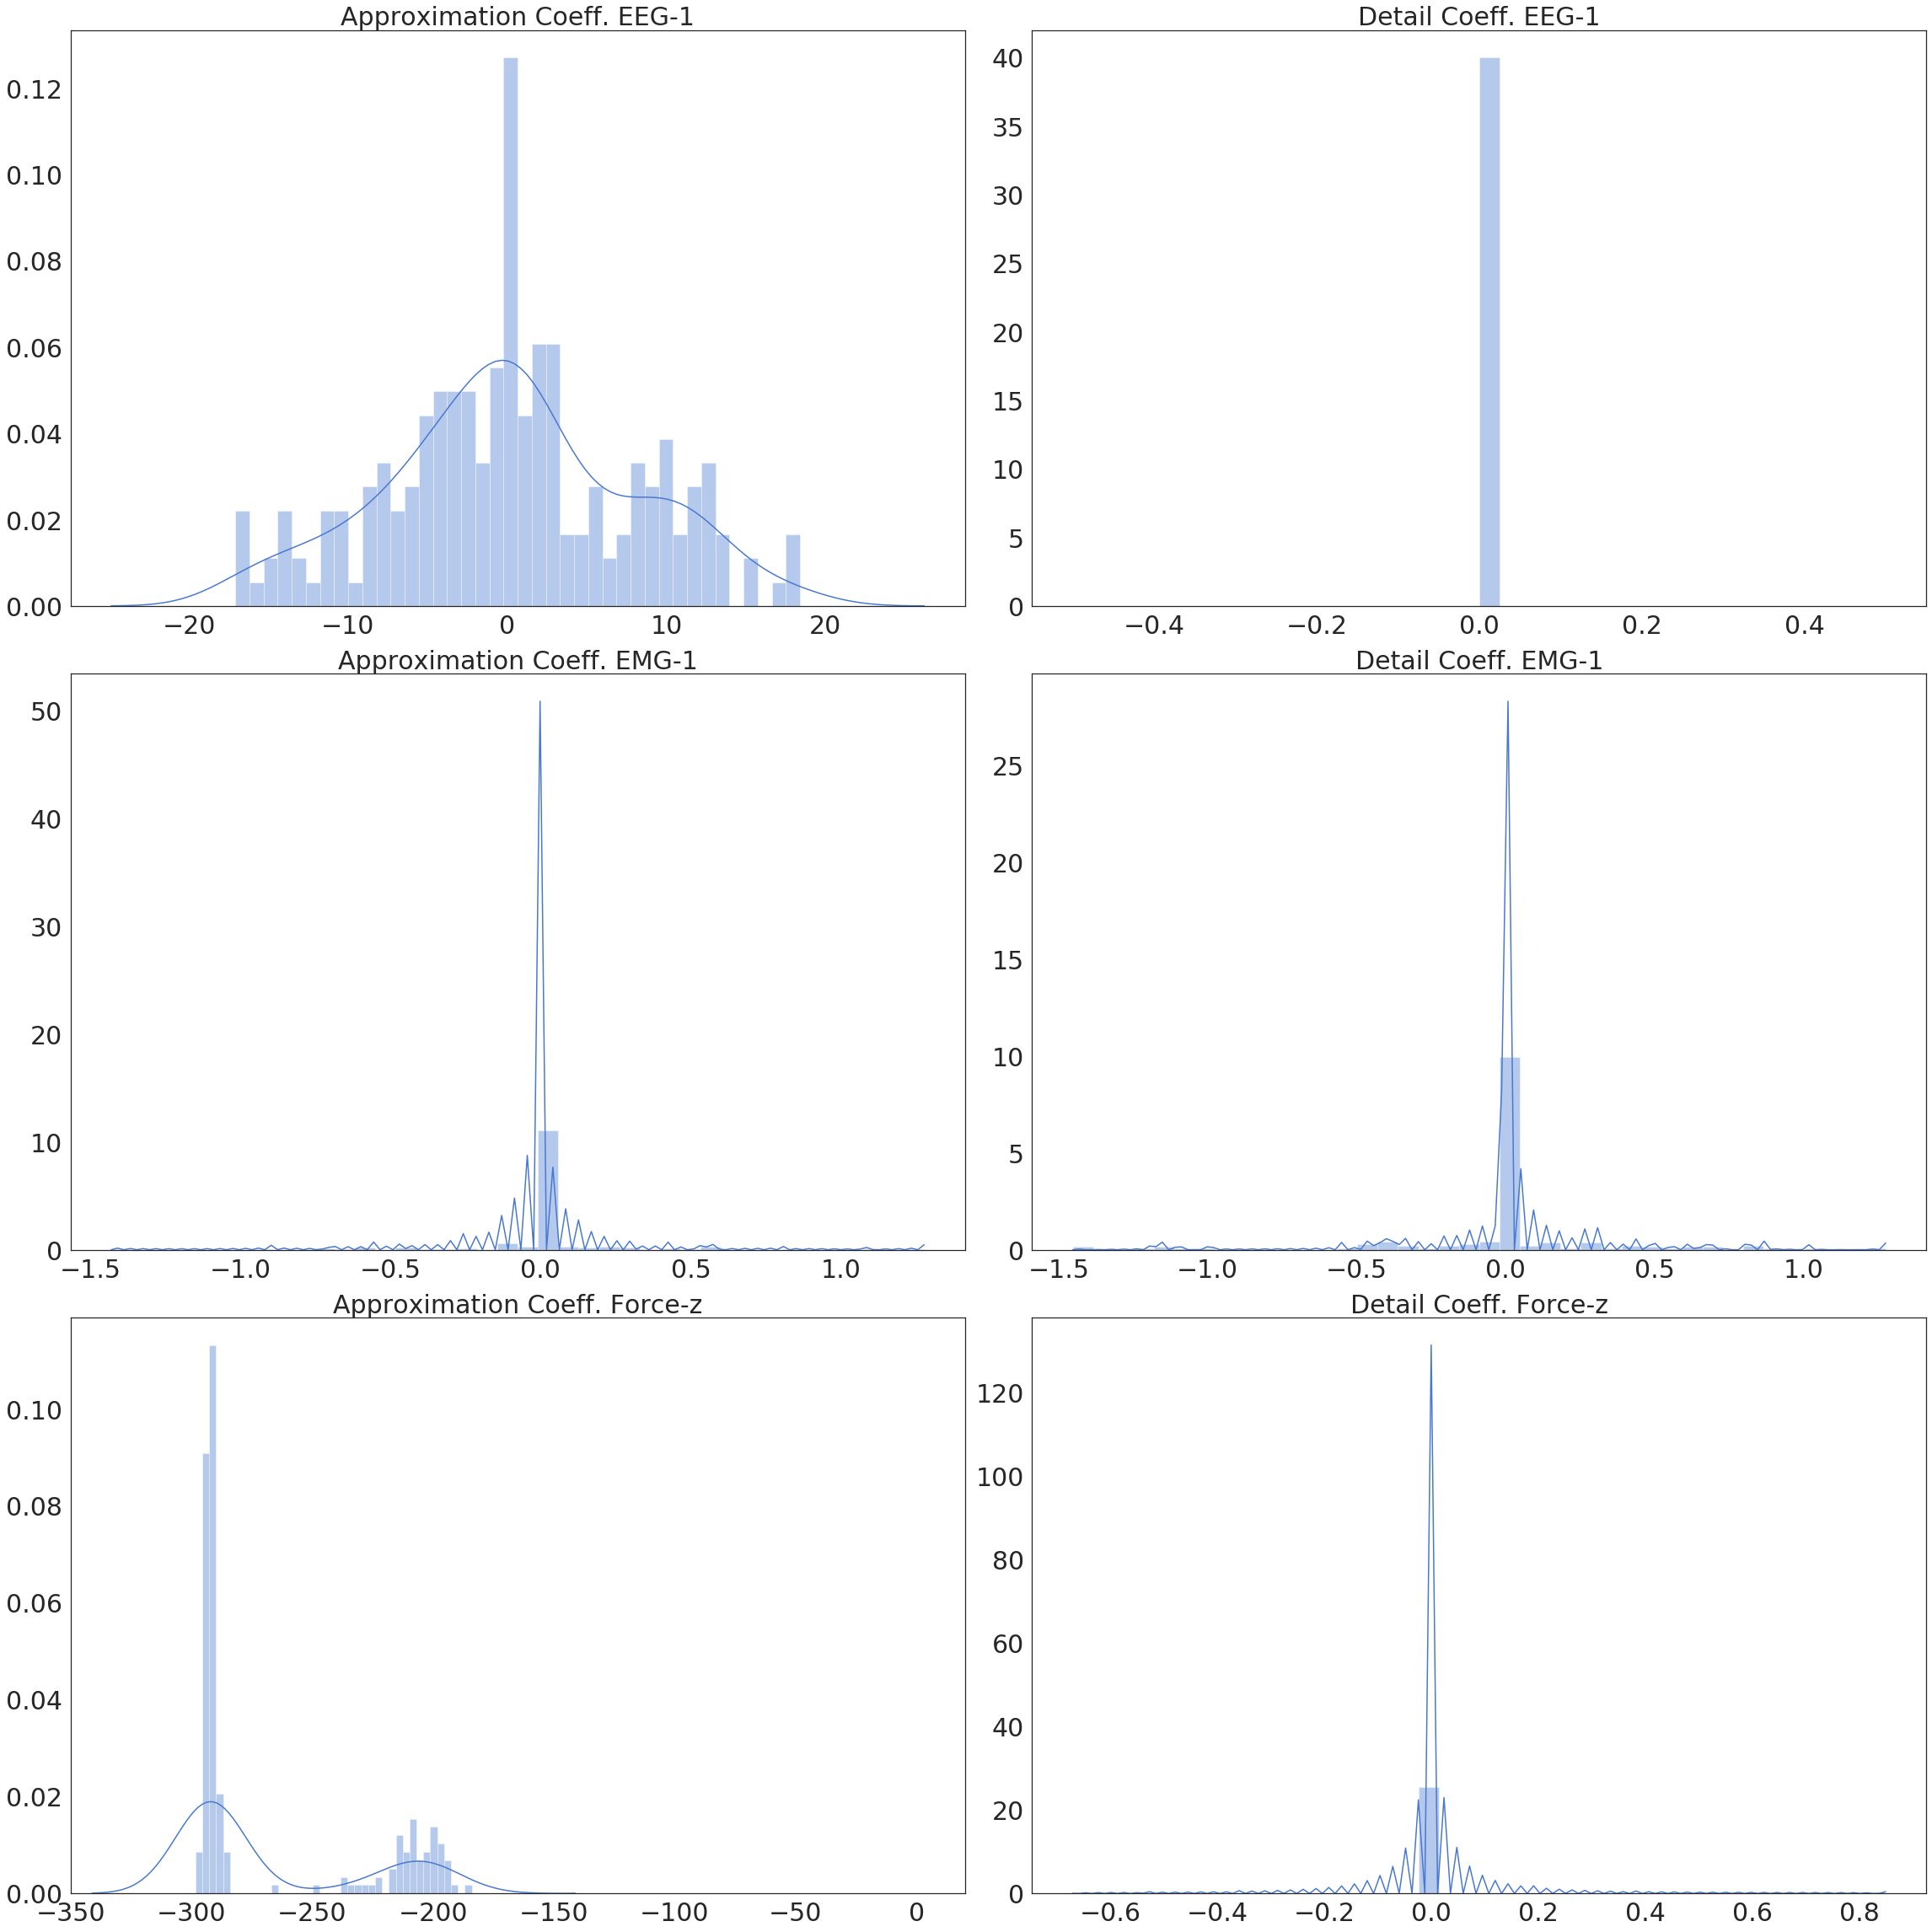

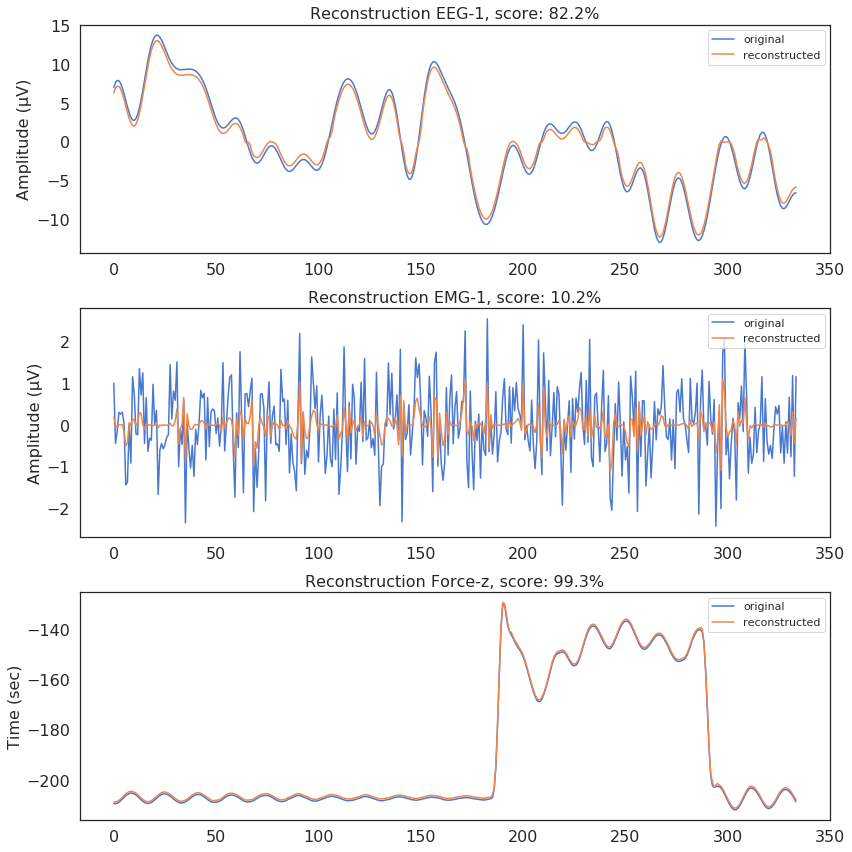

In [10]:
'''
Soft thresholding sets the wavelet coefficients with absolute value below the threshold to 0 and
other coefficients towards the origin by the magnitude of threshold.

Hard thresholding just sets the wavelet coefficients with absolute value below the threshold to 0.
'''
thresholded_list_of_coeffs = []

def threshold_coeffs(coeffs, threshold=1.0, soft=True): # set threshold 0.2 for emg channels.
    if soft == True:
        return [0 if abs(coef)<threshold else coef-np.sign(coef)*threshold for coef in coeffs]
    else:
        return [0 if abs(coef)<threshold else coef for coef in coeffs]

for coeffs in list_of_coeffs:
    thresholded_list_of_coeffs.append(threshold_coeffs(coeffs))

hist_dwtCoeffs(thresholded_list_of_coeffs)

# Plot the reconstructed signals and show reconstruction scores
scores, reconstructed_sigs = [], []
fig, axes = plt.subplots(3, figsize=(12,12), sharex=False)
for i, signal in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    axes[i].plot(time, signal, label='original')
    cA = thresholded_list_of_coeffs[2*i]
    cD = thresholded_list_of_coeffs[2*i+1]
    reconstructed_sigs.append(pywt.idwt(cA, cD, 'db4'))  
    scores.append(get_reconstruction_score(signal, reconstructed_sigs[-1][:-1]))

for i, recon in enumerate(reconstructed_sigs):
    axes[i].plot(time, recon[:-1], label='reconstructed')
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    axes[i].legend(loc='upper right')
    
axes[0].set_title('Reconstruction EEG-1, score: %.1f' %scores[0]+'%', fontsize=16) 
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('Reconstruction EMG-1, score: %.1f' %scores[1]+'%', fontsize=16) 
axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[2].set_title('Reconstruction Force-z, score: %.1f' %scores[2]+'%', fontsize=16) 
axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_ylabel('Time (sec)', fontsize=16)

plt.tight_layout()

### c) Wavelet Data Compression by Parseval's Theorem

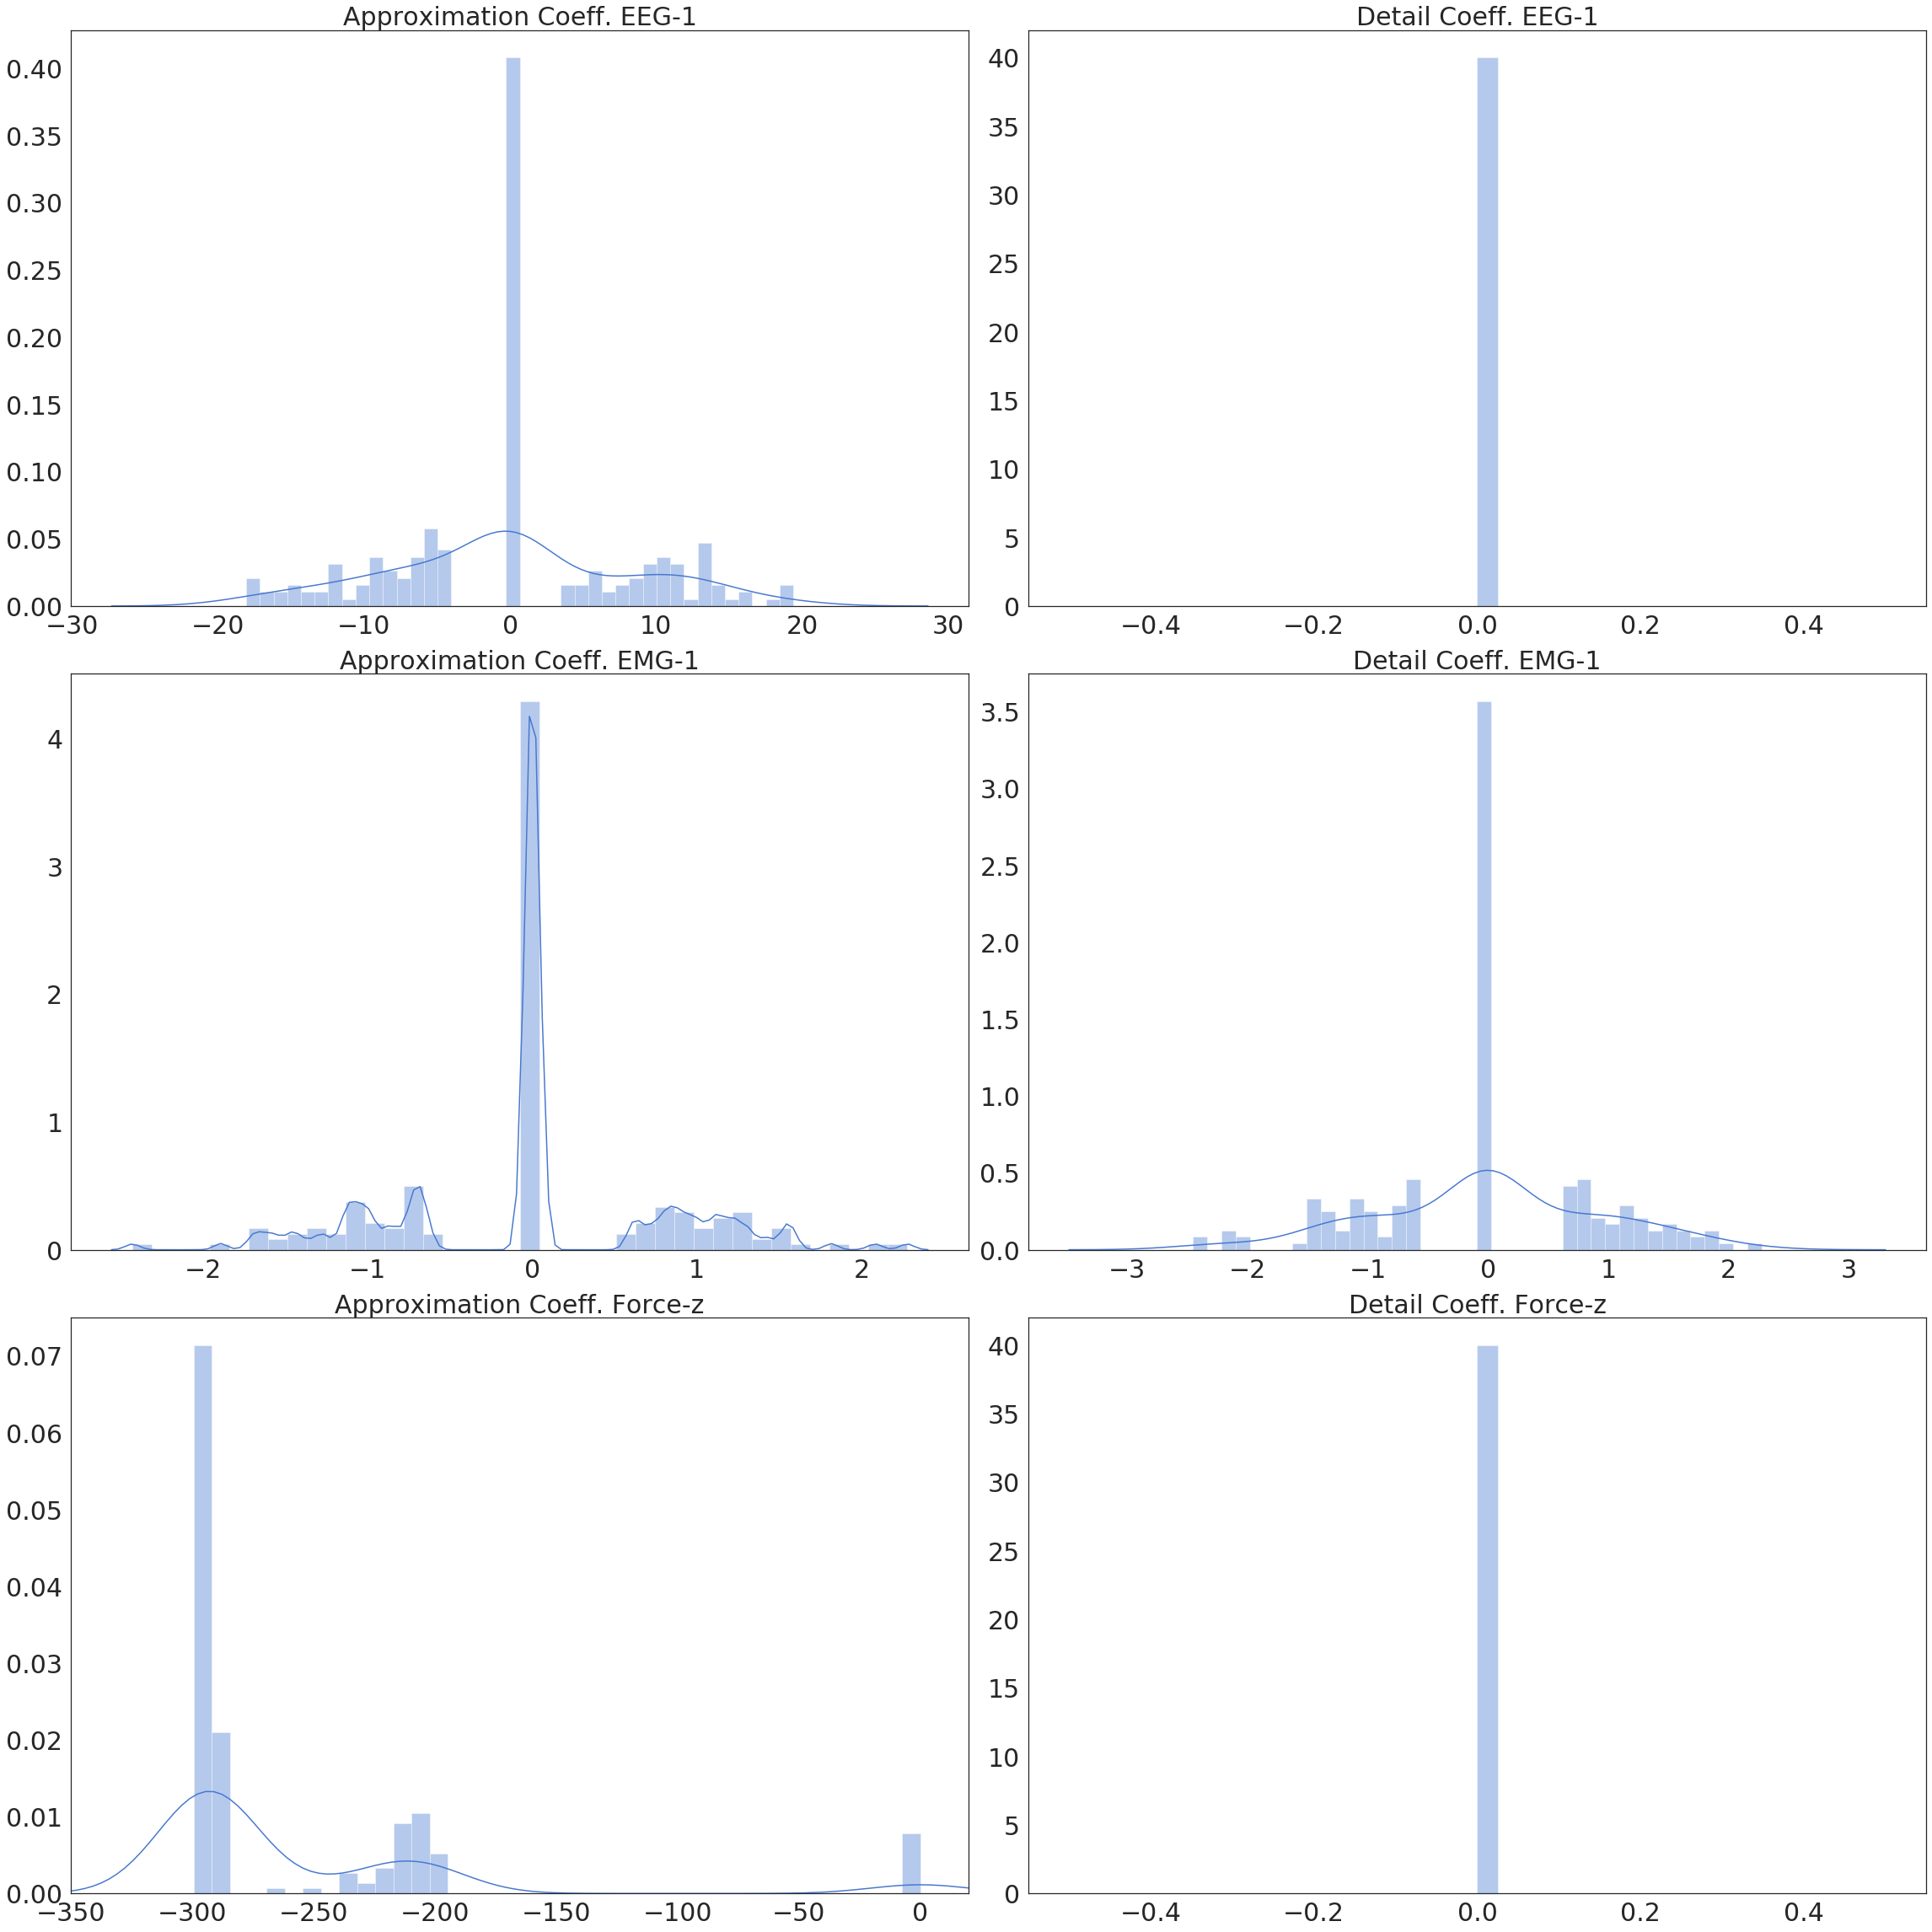

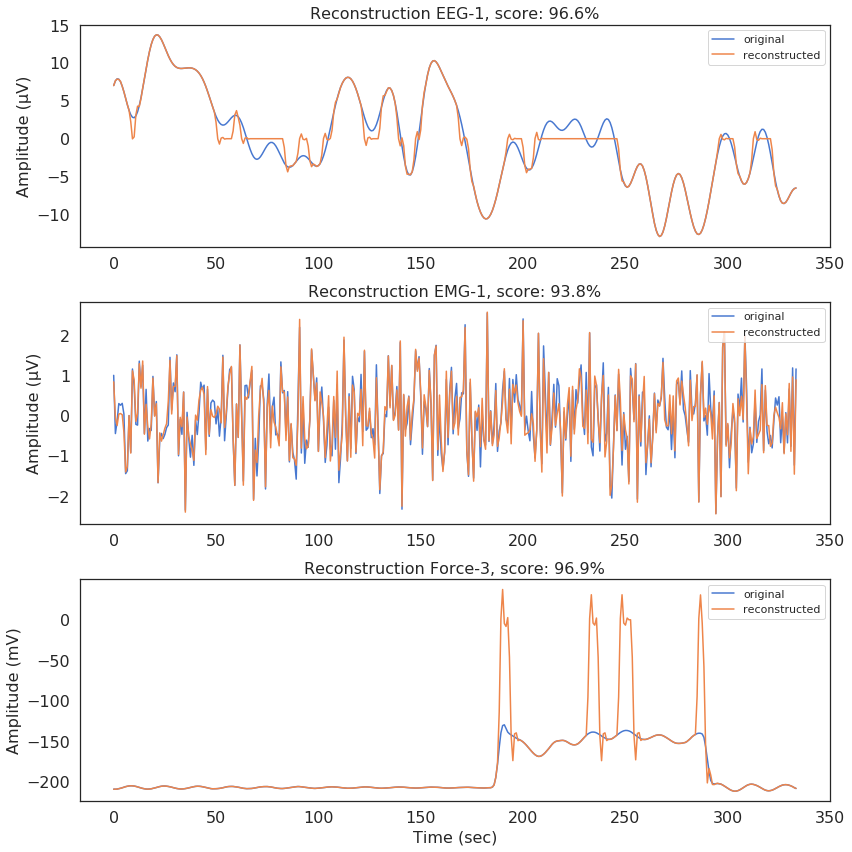

In [11]:
def retain_energy(cA, cD, original_signal, retained_ratio=.99):
    energy = norm(original_signal) ** 2 # energy of the original signal
    c = cA + cD 
    sorted_c = sorted(c, key=abs)[::-1] # dwt coeffs sorted in a decreasing order of their magnitude
    sum, i = 0, 0
    # evaluate the energy of the compressed signal until a certain amount of energy 
    # from the original signal is retained.
    while sum <= energy * retained_ratio:
        sum += sorted_c[i] ** 2
        i += 1
    th = abs(sorted_c[i])
    cA = threshold_coeffs(cA, threshold=th, soft=False)
    cD = threshold_coeffs(cD, threshold=th, soft=False)
    return cA, cD

retained_list_of_coeffs = []

# split the list of coefficients into [cA, cD] for each signal
split_list = [list_of_coeffs[i:i+2] for i in range(0, len(list_of_coeffs), 2)]
for coeffs, signal in zip(split_list, [eeg_signal_1, emg_signal_1, force_signal_3]):
    retained_list_of_coeffs.append(retain_energy(coeffs[0], coeffs[1], signal)[0])
    retained_list_of_coeffs.append(retain_energy(coeffs[0], coeffs[1], signal)[1])

hist_dwtCoeffs(retained_list_of_coeffs)

# Plot the reconstructed signals and show reconstruction scores
scores, reconstructed_sigs = [], []
fig, axes = plt.subplots(3, figsize=(12,12), sharex=False)
for i, signal in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    axes[i].plot(time, signal, label='original')
    cA = retained_list_of_coeffs[2*i]
    cD = retained_list_of_coeffs[2*i+1]
    reconstructed_sigs.append(pywt.idwt(cA, cD, 'db4'))  
    scores.append(get_reconstruction_score(signal, reconstructed_sigs[-1][:-1]))

for i, recon in enumerate(reconstructed_sigs):
    axes[i].plot(time, recon[:-1], label='reconstructed')
    axes[i].tick_params(axis='both', which='major', labelsize=16)
    axes[i].legend(loc='upper right')
    
axes[0].set_title('Reconstruction EEG-1, score: %.1f' %scores[0]+'%', fontsize=16) 
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('Reconstruction EMG-1, score: %.1f' %scores[1]+'%', fontsize=16) 
axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[2].set_title('Reconstruction Force-3, score: %.1f' %scores[2]+'%', fontsize=16) 
axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_xlabel('Time (sec)', fontsize=16)

plt.tight_layout()


# Vector Auto-Regression Based on DWT Coefficients

In [12]:
# Split the data for train and test
# train data and test data are a list of data frames. 
# Each element of the list corresponds to a trial 
train_ratio = 0.5
num_train = int(train_ratio*len(shuffled_data_splitBy_trials))
train_data, test_data = data_splitBy_trials[:num_train], data_splitBy_trials[num_train:]

wl_columns=['cA_EEG-1','cD_EEG-1','cA_EEG-2','cD_EEG-2','cA_EEG-3',
            'cD_EEG-3','cA_EEG-4','cD_EEG-4','cA_EEG-5','cD_EEG-5',
            'cA_EEG-6','cD_EEG-6','cA_EEG-7','cD_EEG-7','cA_EEG-8',
            'cD_EEG-8','cA_EEG-9','cD_EEG-9','cA_EEG-10','cD_EEG-10', 
            'cA_EEG-11','cD_EEG-11','cA_EEG-12','cD_EEG-12', 'cA_EEG-13',
            'cD_EEG-13','cA_EEG-14','cD_EEG-14','cA_EMG-1','cD_EMG-1',
            'cA_EMG-2','cD_EMG-2','cA_EMG-3','cD_EMG-3','cA_EMG-4','cD_EMG-4',
            'cA_Force-x','cD_Force-x', 'cA_Force-y','cD_Force-y', 
            'cA_Force-z','cD_Force-z']

# take the discrete wavelet coefficients of train and test data for each trial
def get_wavelet(data):
    wavelet_coef = pd.DataFrame(columns=wl_columns)
    th = 14*[1] + 4*[0.2] + 3*[1] # soft threshold list for all channels
    wavelet_list = []
    for i in tqdm_notebook(range(len(data)), ascii=True):  # for each trial
        for j in range(num_ch):
            cA, cD = pywt.dwt(data[i].iloc[:,j].values, 'db4')
            # Apply soft-thresholding on DWT coeffs
            wavelet_coef[wl_columns[2*j]] = threshold_coeffs(cA, threshold=th[j], soft=True)
            wavelet_coef[wl_columns[2*j+1]] = threshold_coeffs(cD, threshold=th[j], soft=True)
        wavelet_list.append(wavelet_coef)
        # delete the df wavelet_coef for the next trial
        wavelet_coef = wavelet_coef.drop(wavelet_coef.index[:])
    return wavelet_list

train_wavelet = get_wavelet(train_data)
test_wavelet = get_wavelet(test_data)
test_wavelet[0].tail(10) # last 10 DWT coefficients of the first trial

,cA_EEG-1,cD_EEG-1,cA_EEG-2,cD_EEG-2,cA_EEG-3,cD_EEG-3,cA_EEG-4,cD_EEG-4,cA_EEG-5,cD_EEG-5,...,cA_EMG-3,cD_EMG-3,cA_EMG-4,cD_EMG-4,cA_Force-x,cD_Force-x,cA_Force-y,cD_Force-y,cA_Force-z,cD_Force-z
454,-4.678719,0,0.272501,0,3.473649,0,1.310263,0,3.810955,0,...,-0.990360,-1.898397,0.012127,0.874695,-659.717312,0,-356.465931,0,-0.364114,0
455,-1.470717,0,1.938108,0,7.683527,0,5.350701,0,9.243378,0,...,-0.499091,0.615641,0.000000,-1.007724,-659.613384,0,-349.499686,0,-0.363320,0
456,0.000000,0,2.859467,0,11.832498,0,11.148345,0,15.252547,0,...,0.396154,0.476758,-0.654389,-0.816077,-659.892931,0,-343.186380,0,-0.365897,0
457,0.374551,0,3.781939,0,15.462459,0,18.141785,0,21.056655,0,...,0.212658,0.331254,0.200737,1.222450,-659.926456,0,-338.132874,0,-0.367106,0
458,1.623977,0,5.142949,0,18.117382,0,25.210878,0,25.814374,0,...,0.418115,1.028089,0.339871,-1.184049,-659.642327,0,-334.259780,0,-0.369719,0
459,2.607349,0,6.847117,0,19.465669,0,30.977797,0,28.868794,0,...,0.000000,0.968827,-0.650851,0.535872,-659.657545,0,-331.295478,0,-0.372185,0
460,3.179769,0,8.329107,0,19.437265,0,34.273114,0,29.983393,0,...,1.972335,0.026431,-0.279663,-0.822909,-659.953164,0,-327.917400,0,-0.373340,0
461,3.176128,0,8.979373,0,18.365523,0,34.759757,0,29.512970,0,...,-0.140657,-0.439803,0.182450,0.927156,-659.880616,0,-325.986205,0,-0.375463,0
462,2.264325,0,7.943894,0,16.672968,0,32.223116,0,28.127410,0,...,0.000000,-1.224740,0.000000,-0.474315,-659.633300,0,-325.049677,0,-0.377250,0
463,1.960677,0,7.542441,0,16.209289,0,31.363208,0,27.729181,0,...,0.240863,-0.678625,-0.533701,0.933180,-659.574617,0,-324.844638,0,-0.377651,0


In [53]:
print('Number of trials in the training data: %i' %len(train_data))
print('Number of trials in the test data: %i' %len(test_data))

Number of trials in the training data: 1109
Number of trials in the test data: 1109


### Model Lag Order Selection 

In [14]:
# saves bic scores for all model orders:
def save_bic(dataframe, filename, use_saved=False):
    if use_saved==True: return
    lag_bic_scores = np.zeros((1,20))
    for P in tqdm_notebook(range(20), ascii=True):
        model = VAR(dataframe)
        results = model.fit(P+1)
        bic_score = results.bic
        lag_bic_scores[0, P] = bic_score
        np.save(filename, lag_bic_scores)

train_wavelet_df = pd.concat(train_wavelet)
test_wavelet_df = pd.concat(test_wavelet)

# use only approximation coeefficients for eeg avoid columns with 0's,
# in order to yield a positive-semidefinite matrix
eeg_ind_wl = list(range(0, 28, 2))
emg_ind_wl = list(range(28, 36, 1))
force_ind_wl = list(range(36, 42, 1))

# Only EEG (first 28 columns)   
filename = 'VARResults/onlyEEG_lagOrder.npy'
save_bic(train_wavelet_df.iloc[:,eeg_ind_wl], filename)
print("Lag order selection completed for EEG only.")

# Only EMG (28-35 columns)
filename = 'VARResults/onlyEMG_lagOrder.npy'
save_bic(train_wavelet_df.iloc[:,emg_ind_wl], filename)
print("Lag order selection completed for EMG only.")
 
# Only Force (35-41 columns)
filename = 'VARResults/onlyForce_lagOrder.npy'
save_bic(train_wavelet_df.iloc[:,force_ind_wl], filename)
print("Lag order selection completed for Force only.")

# EEG & EMG
filename = 'VARResults/EEG_EMG_lagOrder.npy'
save_bic(train_wavelet_df.iloc[:,eeg_ind_wl+emg_ind_wl], filename)
print("Lag order selection completed for EEG and EMG.")

# EEG & Force
filename = 'VARResults/EEG_Force_lagOrder.npy'
save_bic(train_wavelet_df.iloc[:,eeg_ind_wl+force_ind_wl], filename)
print("Lag order selection completed for EEG and Force.")

# EMG & Force
filename = 'VARResults/EMG_Force_lagOrder.npy'
save_bic(train_wavelet_df.iloc[:,emg_ind_wl+force_ind_wl], filename)
print("Lag order selection completed for EMG and Force.")

# all
filename = 'VARResults/all_lagOrder.npy'
save_bic(train_wavelet_df.iloc[:,eeg_ind_wl+emg_ind_wl+force_ind_wl], filename)
print("Lag order selection completed for all.")


Lag order selection completed for EEG only.



Lag order selection completed for EMG only.



Lag order selection completed for Force only.



Lag order selection completed for EEG and EMG.



Lag order selection completed for EEG and Force.



Lag order selection completed for EMG and Force.



Lag order selection completed for all.


### Model Lag Order Results

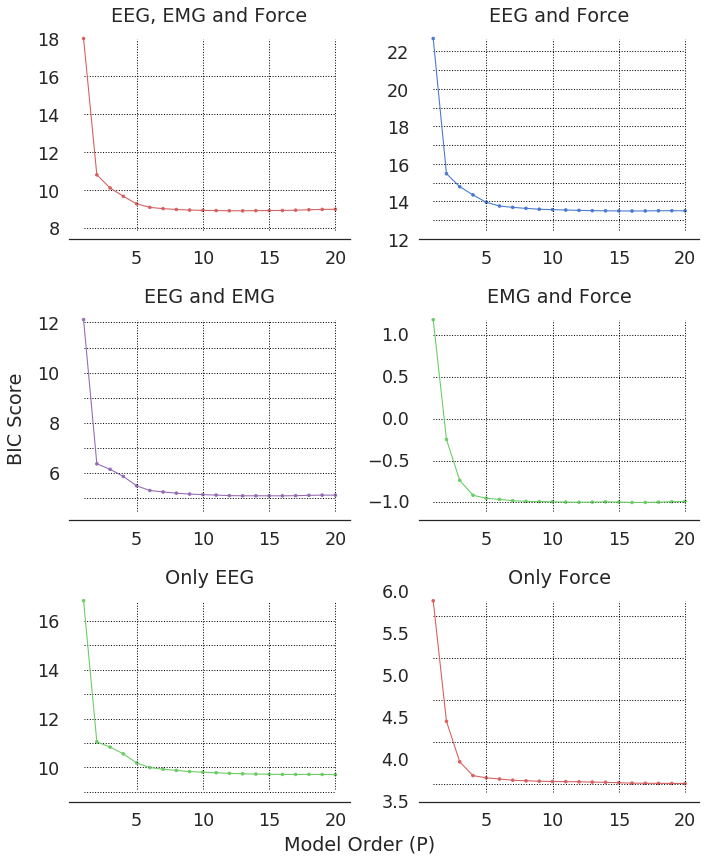

In [15]:
all = np.load('VARResults/all_lagOrder.npy')
only_eeg = np.load('VARResults/onlyEEG_lagOrder.npy')
only_emg = np.load('VARResults/onlyEMG_lagOrder.npy')
only_force = np.load('VARResults/onlyForce_lagOrder.npy')
eeg_emg = np.load('VARResults/EEG_EMG_lagOrder.npy')
eeg_force = np.load('VARResults/EEG_Force_lagOrder.npy')
emg_force = np.load('VARResults/EMG_Force_lagOrder.npy')

BIC = pd.DataFrame({'all': all[0,:],
                    'only_eeg': only_eeg[0,:],
                    'only_emg': only_emg[0,:],
                    'only_force': only_force[0,:],
                    'eeg_emg': eeg_emg[0,:],
                    'eeg_force': eeg_force[0,:],
                    'emg_force': emg_force[0,:]})
model_orders = 1 + np.arange(20)

sns.set(style="white", palette="muted", color_codes=True, font_scale=1.6)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 2, figsize=(10,12), sharex=False)
sns.despine(left=True)

sns.pointplot(x=model_orders, y=BIC['all'], color='r', ax=axes[0,0], scale=0.4).set_title('EEG, EMG and Force')
sns.pointplot(x=model_orders, y=BIC['eeg_force'], color='b', ax=axes[0,1], scale=0.4).set_title('EEG and Force')
sns.pointplot(x=model_orders, y=BIC['eeg_emg'], color='m', ax=axes[1,0], scale=0.4).set_title('EEG and EMG')
sns.pointplot(x=model_orders, y=BIC['emg_force'], color='g', ax=axes[1,1], scale=0.4).set_title('EMG and Force')
sns.pointplot(x=model_orders, y=BIC['only_eeg'], color='g', ax=axes[2,0], scale=0.4).set_title('Only EEG')
sns.pointplot(x=model_orders, y=BIC['only_force'], color='r', ax=axes[2,1], scale=0.4).set_title('Only Force')

for ax in axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# The rest is for some cosmetics of the plots...
# reduce the density of x-axis
for ax in axes.flatten():
    for ind, label in enumerate(ax.get_xticklabels()):
        if (ind+1) % 5 == 0: #every 5th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

# draw vertical lines:
for i in range(4,24,5):
    axes.flatten()[0].vlines(x=i, ymin=BIC['all'].min()-1, ymax=BIC['all'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[1].vlines(x=i, ymin=BIC['eeg_force'].min()-1, ymax=BIC['eeg_force'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[2].vlines(x=i, ymin=BIC['eeg_emg'].min()-0.6, ymax=BIC['eeg_emg'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[3].vlines(x=i, ymin=BIC['emg_force'].min()-0.1, ymax=BIC['emg_force'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[4].vlines(x=i, ymin=BIC['only_eeg'].min()-0.6, ymax=BIC['only_eeg'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[5].vlines(x=i, ymin=BIC['only_force'].min()-0.1, ymax=BIC['only_force'].max(), 
                             color='black', alpha=1, linewidth=1, linestyles='dotted')

# draw horizontal lines:
for i in range(int(BIC['all'].min()), int(BIC['all'].max()+1), 2):
    axes.flatten()[0].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in range(int(BIC['eeg_force'].min()), int(BIC['eeg_force'].max()+1)):
    axes.flatten()[1].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in range(int(BIC['eeg_emg'].min()), int(BIC['eeg_emg'].max()+1)):
    axes.flatten()[2].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in np.arange(BIC['emg_force'].min(), BIC['emg_force'].max(), 0.5):
    axes.flatten()[3].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in range(int(BIC['only_eeg'].min()), int(BIC['only_eeg'].max()+1)):
    axes.flatten()[4].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in np.arange(BIC['only_force'].min(), BIC['only_force'].max(), 0.5):
    axes.flatten()[5].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')

# display and save
f.text(0.5, 0.0, 'Model Order (P)', ha='center')
f.text(0.01, 0.5, 'BIC Score', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("VARResults/lagOrders.pdf", bbox_inches="tight")

### Model Training and Multi-Step Prediction

In [16]:
def show_entry_fields():
    global nPreds, nAhead
    nPreds, nAhead = int(e1.get()), int(e2.get())
    print("nPreds: %s\nnAhead: %s" % (nPreds, nAhead))
    root.destroy()

root = tk.Tk()

window_height = 80
window_width = 350

screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

x_cordinate = int((screen_width/2) - (window_width/2))
y_cordinate = int((screen_height/2) - (window_height/2))

root.geometry("{}x{}+{}+{}".format(window_width, window_height, x_cordinate, y_cordinate))
root.title('Prediction Parameters')

# total number of samples to be predicted one-by-one
tk.Label(root, text="num_predictions (max. 200)").grid(row=0)
# number of samples to be predicted at results.forecast case
tk.Label(root, text="num_ahead").grid(row=1)

e1 = tk.Entry(root)
e2 = tk.Entry(root)

e1.grid(row=0, column=1)
e2.grid(row=1, column=1)

tk.Button(root, text='Submit', command=show_entry_fields).grid(row=3, 
                                                               column=1, 
                                                               sticky=tk.W, 
                                                               pady=4)
tk.mainloop()

nPreds: 200
nAhead: 1


In [17]:
P = 5 # optimal lag order based on BIC plots
# Use these figures by default:
# nPreds = 200 number of samples to be predicted one-by-one
# nAhead = 1 number of samples to be predicted at results.forecast case

def fit_model(train, test, cols, lag_order=P, nPreds=nPreds, nAhead=nAhead):
    assert nAhead <= nPreds, ("number of samples to be predicted at each prediction must be"
                              "less than total number of samples to be predicted")
    model = VAR(train)
    results = model.fit(lag_order)
    forecasted_trials = []
    for i, trial in enumerate(tqdm_notebook(test, ascii=True)):
        forecasts = []
        # sliding window over last P observed samples to predict next nAhead samples
        for j in range(math.floor(nPreds/nAhead)):
            forecasts.extend(results.forecast(trial.iloc[j*nAhead:j*nAhead+lag_order,cols].values, nAhead))
        # convert the list to a pd.DataFrame
        forecasts = pd.DataFrame(forecasts, columns=[wl_columns[x] for x in cols])
        forecasted_trials.append(forecasts)       
    return forecasted_trials

# Only EEG (first 28 columns)   
forecasted_eeg = fit_model(train_wavelet_df.iloc[:,eeg_ind_wl], 
                           test_wavelet, eeg_ind_wl)

# Only EMG (28-35 columns)
forecasted_emg = fit_model(train_wavelet_df.iloc[:,emg_ind_wl], 
                           test_wavelet, emg_ind_wl)

# Only Force (35-41 columns)
forecasted_force = fit_model(train_wavelet_df.iloc[:,force_ind_wl], 
                             test_wavelet, force_ind_wl)

# EEG & EMG
forecasted_eegemg = fit_model(train_wavelet_df.iloc[:,eeg_ind_wl+emg_ind_wl], 
                              test_wavelet, eeg_ind_wl+emg_ind_wl)

# EEG & Force
forecasted_eegforce = fit_model(train_wavelet_df.iloc[:,eeg_ind_wl+force_ind_wl], 
                                test_wavelet, eeg_ind_wl+force_ind_wl)

# EMG & Force
forecasted_emgforce = fit_model(train_wavelet_df.iloc[:,emg_ind_wl+force_ind_wl], 
                                test_wavelet, emg_ind_wl+force_ind_wl)

# all
forecasted_all = fit_model(train_wavelet_df.iloc[:,eeg_ind_wl+emg_ind_wl+force_ind_wl], 
                           test_wavelet, eeg_ind_wl+emg_ind_wl+force_ind_wl)

test_wavelet[0].iloc[:,eeg_ind_wl+emg_ind_wl+force_ind_wl].head(P+5)

,cA_EEG-1,cA_EEG-2,cA_EEG-3,cA_EEG-4,cA_EEG-5,cA_EEG-6,cA_EEG-7,cA_EEG-8,cA_EEG-9,cA_EEG-10,...,cA_EMG-3,cD_EMG-3,cA_EMG-4,cD_EMG-4,cA_Force-x,cD_Force-x,cA_Force-y,cD_Force-y,cA_Force-z,cD_Force-z
0,-31.197581,-53.241555,-1.397682,0.000000,-3.083477,4.806659,-1.610608,-5.459515,-2.702581,-5.721132,...,0.731431,0.000000,-0.051812,0.000000,-660.628700,0,-662.299651,0,-282.455055,0
1,-35.504481,-55.848265,-4.113203,-2.186486,-5.513510,1.947501,-4.293896,-7.490973,-5.827287,-8.048764,...,0.899382,-0.002623,0.000000,0.000000,-660.503755,0,-662.544549,0,-286.878425,0
2,-41.908428,-61.119010,-8.608046,-7.204127,-9.915612,-0.736484,-9.490531,-11.540067,-10.681024,-12.388912,...,-0.139960,1.464079,-0.563319,-1.483369,-660.225944,0,-662.633005,0,-290.032544,0
3,-38.430730,-58.128392,-6.118640,-4.332207,-7.444958,0.000000,-6.546818,-9.230553,-8.004356,-9.921439,...,0.296184,0.000000,-0.078310,-0.030333,-660.368903,0,-662.623756,0,-288.573641,0
4,-32.981641,-54.160477,-2.489850,-0.655931,-4.022706,3.648576,-2.616464,-6.232676,-4.040841,-6.676742,...,1.322918,-0.592526,-0.111944,0.489156,-660.639860,0,-662.389606,0,-284.880800,0
5,-30.068940,-53.047344,-0.786015,0.000000,-2.652188,5.475283,-1.229592,-5.136392,-1.752333,-5.139990,...,-0.525419,-0.509946,0.000000,-0.061060,-660.468868,0,-662.266432,0,-279.487948,0
6,-29.678060,-54.131625,-0.657579,-1.105884,-2.861949,5.656438,-1.690333,-5.198075,-0.577253,-4.332196,...,0.704992,0.000000,0.000000,-0.434486,-660.224711,0,-662.572036,0,-273.212777,0
7,-30.985964,-55.981202,-1.305167,-3.359358,-3.799310,4.885533,-2.864812,-5.506734,0.000000,-3.367336,...,0.000000,-0.391735,0.067326,1.478988,-660.403415,0,-662.629906,0,-269.094768,0
8,-32.768252,-57.104835,-1.883785,-5.260779,-4.669632,3.843231,-3.723896,-5.434561,0.000000,-1.909488,...,-0.503490,-0.249731,0.555761,0.011709,-660.632906,0,-662.383261,0,-268.077631,0
9,-33.930591,-56.670475,-1.879094,-5.994686,-5.085703,2.906439,-3.761798,-4.884203,0.000000,-0.295289,...,-0.038086,0.628966,0.000000,-1.027247,-660.434099,0,-662.296698,0,-269.237969,0


In [18]:
forecasted_all[0].head(5)

,cA_EEG-1,cA_EEG-2,cA_EEG-3,cA_EEG-4,cA_EEG-5,cA_EEG-6,cA_EEG-7,cA_EEG-8,cA_EEG-9,cA_EEG-10,...,cA_EMG-3,cD_EMG-3,cA_EMG-4,cD_EMG-4,cA_Force-x,cD_Force-x,cA_Force-y,cD_Force-y,cA_Force-z,cD_Force-z
0,-30.053036,-51.181286,0.220736,2.246062,-0.874044,6.396041,1.156530,-2.881254,0.259141,-3.064852,...,0.012330,0.013906,0.048505,0.018384,-659.141759,0.060384,-662.420924,-0.003335,-282.635337,0.012258
1,-27.295238,-50.700630,1.316844,1.741870,-0.275589,7.589450,1.393382,-2.585504,1.588567,-2.186527,...,-0.074468,0.016181,0.088770,-0.010588,-658.601210,-0.119517,-662.410416,-0.001764,-276.820664,-0.021265
2,-29.149754,-53.726232,-0.838952,-2.169720,-3.015259,5.464089,-2.275038,-5.212556,-0.096546,-3.722376,...,0.003978,-0.007030,0.074443,0.016423,-657.927706,-0.036236,-662.794802,-0.000260,-270.449797,-0.016843
3,-31.867878,-56.398157,-2.244679,-5.400498,-4.741643,3.725158,-4.257075,-6.044718,-0.059873,-2.891278,...,-0.074341,0.000621,0.016011,-0.016885,-658.572379,-0.003985,-662.711648,0.000267,-267.516079,-0.025179
4,-33.611226,-57.038219,-2.398264,-6.504057,-5.175760,2.947000,-4.311578,-5.356111,0.008056,-0.872601,...,-0.149660,0.026531,0.052682,-0.001852,-659.647970,0.031483,-662.257353,-0.000508,-268.047012,-0.024494


In [19]:
# Add to the coefficients of the forecasted dataframe and test_wavelet_df detail coefficients
# of the eeg and then apply inverse discrete wavelet transform to extract the signal.
cols_to_app = ['cD_EEG-1', 'cD_EEG-2', 'cD_EEG-3', 'cD_EEG-4', 'cD_EEG-5', 'cD_EEG-6',
               'cD_EEG-7', 'cD_EEG-8', 'cD_EEG-9', 'cD_EEG-10', 'cD_EEG-11', 'cD_EEG-12',
               'cD_EEG-13', 'cD_EEG-14']

# add the detail coefficients of eeg the col after the app coefficients for each trial
for i in range(num_eeg_ch):
    [trial.insert(2*i+1, cols_to_app[i], 0) for trial in forecasted_all if cols_to_app[i] not in trial] 
    [trial.insert(2*i+1, cols_to_app[i], 0) for trial in forecasted_eeg if cols_to_app[i] not in trial]
    [trial.insert(2*i+1, cols_to_app[i], 0) for trial in forecasted_eegemg if cols_to_app[i] not in trial]
    [trial.insert(2*i+1, cols_to_app[i], 0) for trial in forecasted_eegforce if cols_to_app[i] not in trial]
        
# list of dataframes, each as the complete forecasted dwt coefficients for a given modality
f_list = [forecasted_eeg, forecasted_emg, forecasted_force, forecasted_eegemg, 
          forecasted_eegforce, forecasted_emgforce, forecasted_all]

forecasted_eegemg[0].head(5)

,cA_EEG-1,cD_EEG-1,cA_EEG-2,cD_EEG-2,cA_EEG-3,cD_EEG-3,cA_EEG-4,cD_EEG-4,cA_EEG-5,cD_EEG-5,...,cA_EEG-14,cD_EEG-14,cA_EMG-1,cD_EMG-1,cA_EMG-2,cD_EMG-2,cA_EMG-3,cD_EMG-3,cA_EMG-4,cD_EMG-4
0,-30.088906,0,-51.202651,0,0.225004,0,2.268566,0,-0.852155,0,...,-11.752016,0,-0.053618,-0.009568,-0.009705,-0.029629,0.013362,0.015668,0.049964,0.014403
1,-27.326301,0,-50.735722,0,1.318356,0,1.759753,0,-0.255210,0,...,-11.987486,0,-0.020656,0.016920,0.021108,-0.031526,-0.072511,0.018376,0.090500,-0.014776
2,-29.182636,0,-53.780978,0,-0.854997,0,-2.180474,0,-3.021938,0,...,-12.520794,0,-0.062619,-0.021667,0.006430,0.003919,0.006119,-0.004479,0.077807,0.012960
3,-31.890273,0,-56.451826,0,-2.262259,0,-5.416615,0,-4.752819,0,...,-9.974249,0,0.022216,-0.009038,0.002250,-0.027359,-0.072123,0.002097,0.018578,-0.019209
4,-33.624147,0,-57.087785,0,-2.416298,0,-6.527017,0,-5.190862,0,...,-6.268041,0,0.010110,-0.007314,-0.014449,-0.020197,-0.148495,0.027310,0.054508,-0.002429


In [20]:
eeg_ind = list(range(0,14))
emg_ind = list(range(14,18))
force_ind = list(range(18,21))
c_list = [[columns[i] for i in eeg_ind], 
          [columns[i] for i in emg_ind], 
          [columns[i] for i in force_ind],
          [columns[i] for i in eeg_ind + emg_ind],
          [columns[i] for i in eeg_ind + force_ind], 
          [columns[i] for i in emg_ind + force_ind],
          [columns[i] for i in eeg_ind + emg_ind + force_ind]]

# apply inverse discrete wavelet transform to each trial and extract the signals:
def apply_idwt(f, c):
    list_of_forecasts = []
    for trial in f:
        forecast = pd.DataFrame(columns=c)
        for i in range(len(forecast.columns)):
            forecast.iloc[:,i] = pywt.idwt(trial.iloc[:,2*i], 
                                           trial.iloc[:,2*i+1], 'db4')[:-1]
        list_of_forecasts.append(forecast)
    return list_of_forecasts      

# s_list is a list of list of dataframes, each one is the predicted signal for a specific modality
s_list = []
# wl_tuple is the tuple of forecasted dwl coeffs and columns is corresponding modality dataframe's columns
for f,c in zip(f_list, c_list):
    s_list.append(apply_idwt(f,c))

In [21]:
# Select an input modality to plot the predictions:
results_for_eeg = 0
results_for_eegemg = 3
results_for_eegforce = 4
results_for_all = -1

def getit():
    global value
    value = v.get()
    
def printit():
    try:
        global value
        if value==0:
            print("Only EEG Selected")
            root.destroy()
        elif value==3:
            print("EEG & EMG Selected")
            root.destroy()
        elif value==4:
            print("EEG & Force Selected")
            root.destroy()
        elif value==-1:
            print("EEG, EMG & Force Selected")
            root.destroy()
        del value
    except NameError as e:
        value = 0 
        
root = tk.Tk()

window_height = 100
window_width = 500

screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

x_cordinate = int((screen_width/2) - (window_width/2))
y_cordinate = int((screen_height/2) - (window_height/2))

root.geometry("{}x{}+{}+{}".format(window_width, window_height, x_cordinate, y_cordinate))
root.title('Modality Selection')
v = tk.IntVar(value=0) # start with the values of one of the buttons
tk.Label(root, text="""Choose an input modality to plot the predictions""",
        justify = tk.LEFT, padx=20).pack()
rb1 = tk.Radiobutton(root, text="Only EEG", padx=20, variable=v, value=0, command=getit).pack(anchor=tk.W)
rb2 = tk.Radiobutton(root, text="EEG & EMG", padx=20, variable=v, value=3, command=getit).pack(anchor=tk.W)
rb3 = tk.Radiobutton(root, text="EEG & Force", padx=20, variable=v, value=4, command=getit).pack(anchor=tk.W)
rb4 = tk.Radiobutton(root, text="All", padx=20, variable=v, value=-1, command=getit).pack(anchor=tk.W)
b = tk.Button(root, text="Submit", command=printit).pack(anchor=tk.W)

root.mainloop()

EEG, EMG & Force Selected


### Visualizing Predictions Over Test Data in Frequency Domain

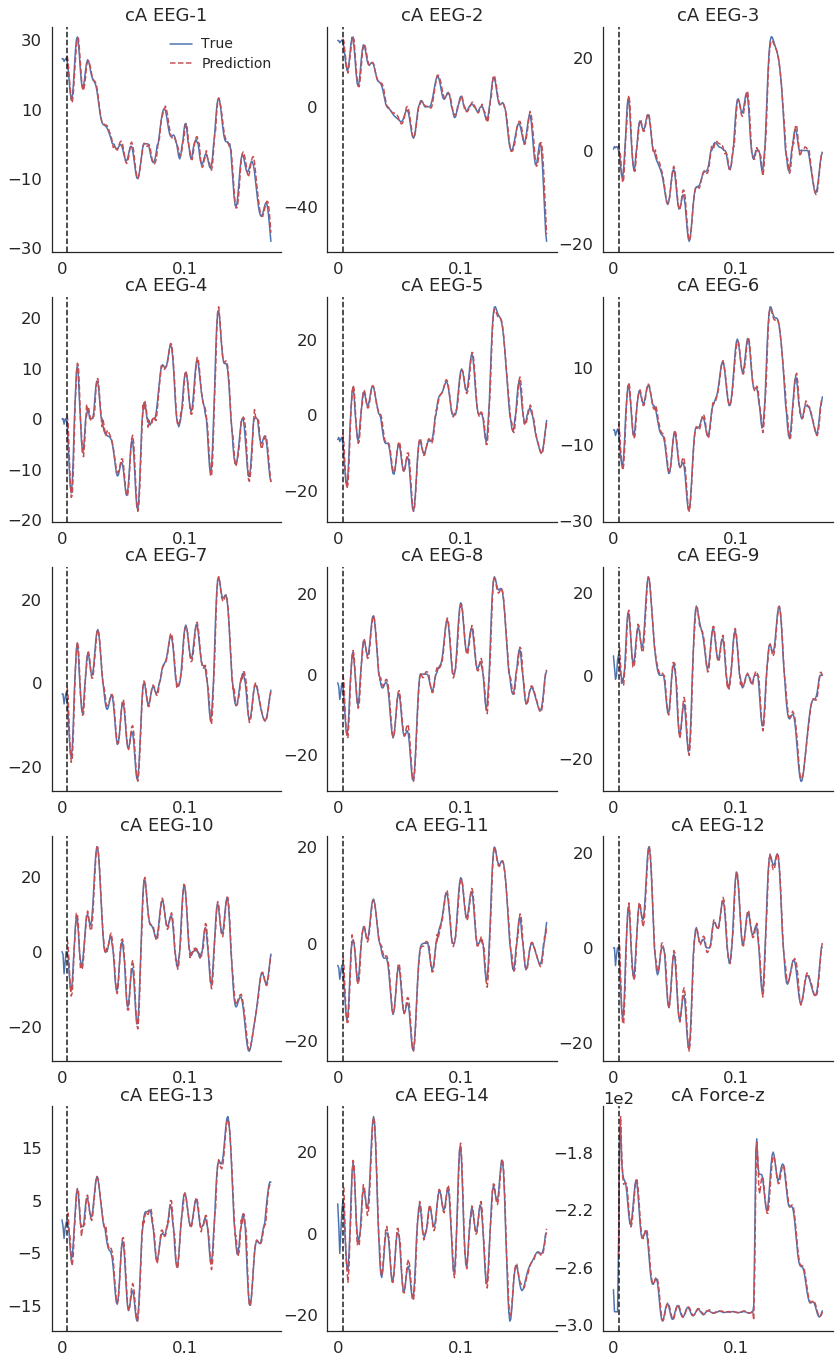

In [51]:
trial_id = 500

# Plot the predictions in frequency domain given thresholded DWT coeffs for 
# different combinations of eeg+emg+force:
modality = v.get()

sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)
# Set up the matplotlib figure (all forecasts subplot figure)
f, axes = plt.subplots(5, 3, figsize=(14, 24), sharex=False, sharey=False)
sns.despine()

x_gt=np.arange(0, (nPreds+P)/fs, 1/fs)
x_pred=np.arange(P/fs, (nPreds+P)/fs, 1/fs)

T = math.floor(10*(nPreds+P)/fs) + 1

if T != 1:
    z = [decimal.Decimal(i) / decimal.Decimal(10) for i in range(0, T)]
else:
    T = math.floor(100*(nPreds+P)/fs) + 1
    z = [decimal.Decimal(i) / decimal.Decimal(100) for i in range(0, T, 2)]

plt.setp(axes, xticks=z, xticklabels=z)

for j in range(1,15,1):
    sns.set()
    axes[math.floor((j-1)/3),(j-1)%3].plot(x_gt, test_wavelet[trial_id].iloc[:nPreds+P, 2*(j-1)].values, 
                                           color='b', label="True")
    axes[math.floor((j-1)/3), (j-1)%3].plot(x_pred, f_list[modality][trial_id].iloc[:nPreds, 2*(j-1)].values, 
                                            color='r', linestyle='--', label="Prediction")
    axes[math.floor((j-1)/3), (j-1)%3].axvline(x=P/fs, linestyle='--', color='k')
    axes[math.floor((j-1)/3), (j-1)%3].title.set_text("cA EEG-%i" %j)
    axes[math.floor((j-1)/3), (j-1)%3].set_yticks(axes[math.floor((j-1)/3), (j-1)%3].get_yticks()[1:-1:2])
    axes[0, 0].legend(frameon=False)
    plt.setp(axes[0, 0].get_legend().get_texts(), fontsize='14')

if modality in [results_for_all, results_for_eegforce]: #force coefficient predictions exist
    axes[4,2].plot(x_gt, test_wavelet[trial_id].iloc[:nPreds+P, -2].values, 
                   color='b', label="True")
    axes[4,2].plot(x_pred, f_list[modality][trial_id].iloc[:nPreds, -2].values, color='r', 
                   linestyle='--', label="Prediction")
    axes[4,2].axvline(x=P/fs, linestyle='--', color='k')
    axes[4,2].ticklabel_format(axis='y', style='sci', scilimits=(4,-4))
    axes[4,2].title.set_text("cA Force-z")
    axes[4,2].set_yticks(axes[4, 2].get_yticks()[1:-1:2])
    #axes[4,2].legend() 

plt.savefig("VARResults/predictions_waveletDomain.pdf", bbox_inches="tight")

### Visualizing Predictions Over Test Data in Time Domain

First P (lag order) discrete wavelet coefficients correspond to first 2*(P-3) time samples. There is no time-series prediction within this time frame.

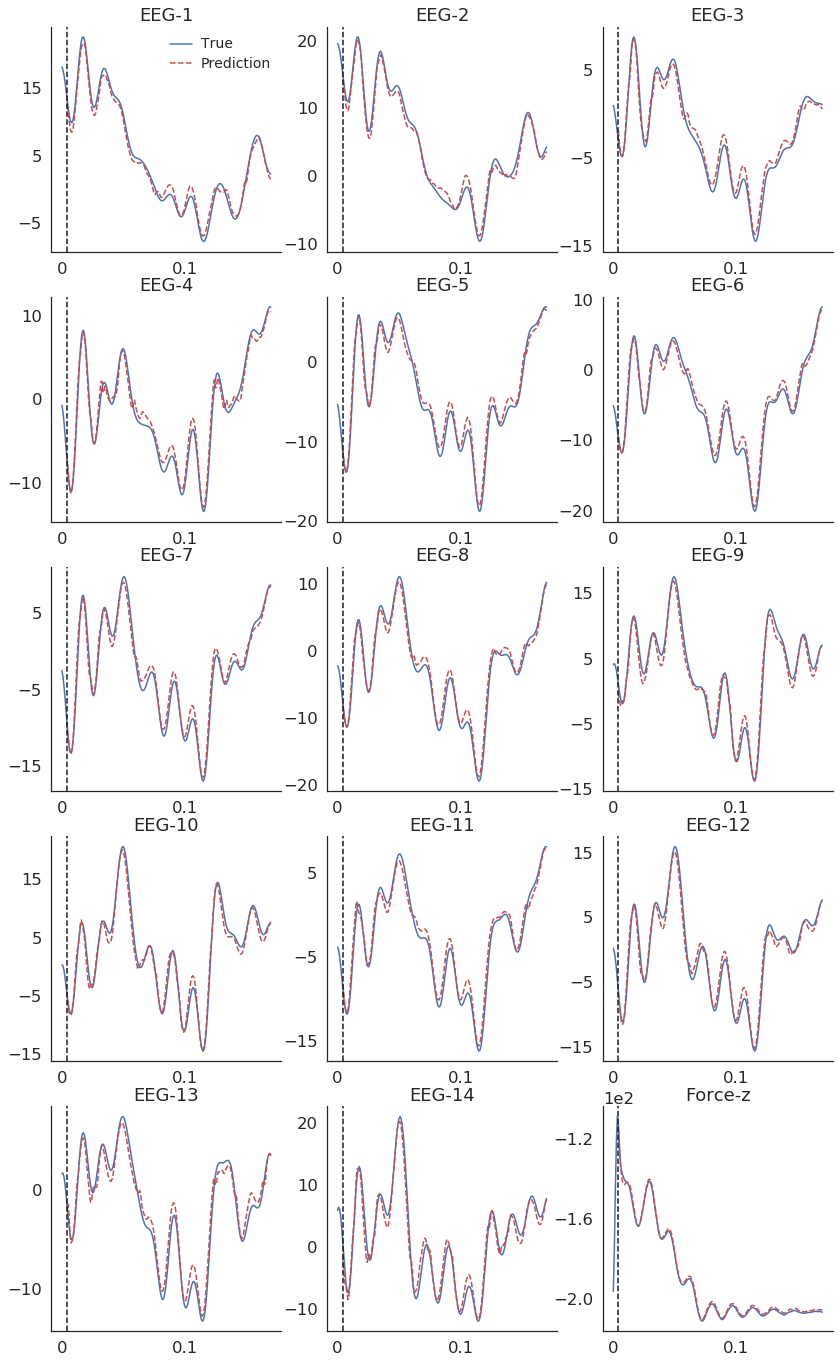

In [58]:
# Plot the predictions in time domain given thresholded DWT coeffs 
# for different combinations of eeg+emg+force:
 
sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)
# Set up the matplotlib figure (all forecasts subplot figure)
f, axes = plt.subplots(5, 3, figsize=(14, 24), sharex=False, sharey=False)
sns.despine()

plt.setp(axes, xticks=z, xticklabels=z)

for j in range(1,15,1):
    sns.set()
    axes[math.floor((j-1)/3),(j-1)%3].plot(x_gt, test_data[trial_id].iloc[2*(P-3):2*(P-3)+nPreds+P, j-1].values, 
                                           color='b', label="True")
    axes[math.floor((j-1)/3), (j-1)%3].plot(x_pred, s_list[modality][trial_id].iloc[:nPreds, j-1].values, 
                                            color='r', linestyle='--', label="Prediction")
    axes[math.floor((j-1)/3), (j-1)%3].axvline(x=P/fs, linestyle='--', color='k')
    axes[math.floor((j-1)/3), (j-1)%3].title.set_text("EEG-%i" %j)
    axes[math.floor((j-1)/3), (j-1)%3].set_yticks(axes[math.floor((j-1)/3), (j-1)%3].get_yticks()[1:-1:2])
    axes[0, 0].legend(frameon=False)
    plt.setp(axes[0, 0].get_legend().get_texts(), fontsize='14')

if modality in [results_for_all, results_for_eegforce]: #force predictions exist
    axes[4,2].plot(x_gt, test_data[trial_id].iloc[2*(P-3):2*(P-3)+nPreds+P, -1].values, 
                   color='b', label="True")
    axes[4,2].plot(x_pred, s_list[modality][trial_id].iloc[:nPreds, -1].values, color='r', 
                   linestyle='--', label="Prediction")
    axes[4,2].axvline(x=P/fs, linestyle='--', color='k')
    axes[4,2].ticklabel_format(axis='y', style='sci', scilimits=(4,-4))
    axes[4,2].title.set_text("Force-z")
    axes[4,2].set_yticks(axes[4, 2].get_yticks()[1:-1:2])
    #axes[4,2].legend() 

plt.savefig("VARResults/predictions_timeDomain.pdf", bbox_inches="tight")

### Displaying Goodness of Fit Performance for Different Input Combinations

In [59]:
'''
Return the mean absolute percentage error between the true signal and prediction
https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
'''
def find_mape(true, pred):
    return 100 * np.mean(np.abs((true-pred)/true))

###### MAPE for only EEG prediction ######
eeg_errs = []
for i, test_trial in enumerate(test_data):
    sum_eeg_err = 0
    for j in eeg_ind:
        # i, which is 1 sample for each trial,
        # because the reconstructed signal is 1 sample longer than the original
        sum_eeg_err += find_mape(test_trial.iloc[2*P:2*P+nPreds, j].values, 
                                 s_list[0][i].iloc[:nPreds, j].values)
    eeg_errs.append(sum_eeg_err / num_eeg_ch)

# Save the RMSE as a dataframe:
err_df = pd.DataFrame({'eeg': np.asarray(eeg_errs)})
err_df.to_pickle("err_bars_forEEGOnly.pkl")


###### MAPE for only FORCE prediction ######
force_errs = []
for i, test_trial in enumerate(test_data):
    force_errs.append(find_mape(test_trial.iloc[2*P:2*P+nPreds, -1].values, 
                                s_list[2][i].iloc[:nPreds, -1].values)) 

# Save the RMSE as a dataframe:
err_df = pd.DataFrame({'force': np.asarray(force_errs)})
err_df.to_pickle("err_bars_forForceOnly.pkl")


###### MAPE for EEG and FORCE prediction ######
eeg_errs, force_errs = [], []
for i, test_trial in enumerate(test_data):
    sum_eeg_err = 0
    for j in eeg_ind:
        # i, which is 1 sample for each trial,
        # because the reconstructed signal is 1 sample longer than the original
        sum_eeg_err += find_mape(test_trial.iloc[2*P:2*P+nPreds, j].values, 
                                 s_list[4][i].iloc[:nPreds, j].values)
    eeg_errs.append(sum_eeg_err / num_eeg_ch)   
    force_errs.append(find_mape(test_trial.iloc[2*P:2*P+nPreds, -1].values, 
                                s_list[4][i].iloc[:nPreds, -1].values)) 

# Save the RMSE as a dataframe:
err_df = pd.DataFrame({'eeg': np.asarray(eeg_errs),
                       'force': np.asarray(force_errs)})
err_df.to_pickle("err_bars_forEEGandForce.pkl")


###### MAPE for EMG and FORCE prediction ######
force_errs = []
for i, test_trial in enumerate(test_data):
    force_errs.append(find_mape(test_trial.iloc[2*P:2*P+nPreds, -1].values, 
                                s_list[5][i].iloc[:nPreds, -1].values)) 

# Save the RMSE as a dataframe:
err_df = pd.DataFrame({'force': np.asarray(force_errs)})
err_df.to_pickle("err_bars_forEMGandForce.pkl")


# MAPE for EEG and EMG prediction
eeg_errs = []
for i, test_trial in enumerate(test_data):
    sum_eeg_err = 0
    for j in eeg_ind:
        sum_eeg_err += find_mape(test_trial.iloc[2*P:2*P+nPreds, j].values, 
                                 s_list[3][i].iloc[:nPreds, j].values)
    eeg_errs.append(sum_eeg_err / num_eeg_ch)

# Save the RMSE as a dataframe:
err_df = pd.DataFrame({'eeg': np.asarray(eeg_errs)})
err_df.to_pickle("err_bars_forEEGandEMG.pkl")


# MAPE for ALL modalities (EEG, EMG and FORCE prediction)
eeg_errs, force_errs = [], []
for i, test_trial in enumerate(test_data):
    sum_eeg_err = 0
    for j in eeg_ind:
        # i, which is 1 sample for each trial,
        # because the reconstructed signal is 1 sample longer than the original
        sum_eeg_err += find_mape(test_trial.iloc[2*P:2*P+nPreds, j].values, 
                                 s_list[-1][i].iloc[:nPreds, j].values)
    eeg_errs.append(sum_eeg_err / num_eeg_ch)   
    force_errs.append(find_mape(test_trial.iloc[2*P:2*P+nPreds, -1].values, 
                                s_list[-1][i].iloc[:nPreds, -1].values)) 

# Save the RMSE as a dataframe:
err_df = pd.DataFrame({'eeg': np.asarray(eeg_errs),
                       'force': np.asarray(force_errs)})
err_df.to_pickle("err_bars_forAll.pkl")

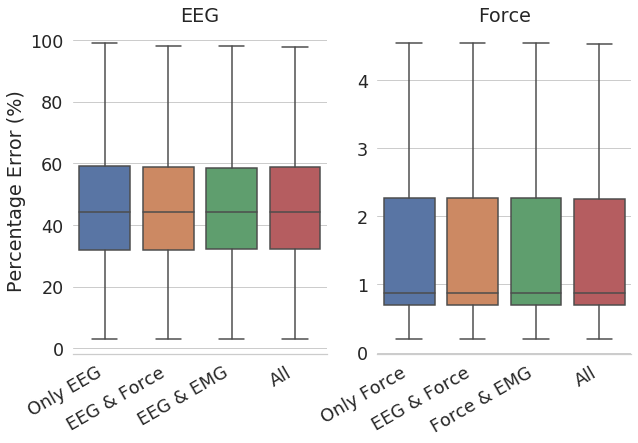

In [60]:
onlyEEG_errs = pd.read_pickle("./err_bars_forEEGOnly.pkl")
onlyForce_errs = pd.read_pickle("./err_bars_forForceOnly.pkl")
EEGandForce_errs = pd.read_pickle("./err_bars_forEEGandForce.pkl")
EMGandForce_errs = pd.read_pickle("./err_bars_forEMGandForce.pkl")
EEGandEMG_errs = pd.read_pickle("./err_bars_forEEGandEMG.pkl")
all_errs = pd.read_pickle("./err_bars_forAll.pkl")

force_box_plot = pd.DataFrame({'Only Force': onlyForce_errs['force'].values, 
                               'EEG & Force': EEGandForce_errs['force'].values, 
                               'Force & EMG': EMGandForce_errs['force'].values, 
                               'All': all_errs['force'].values})
eeg_box_plot = pd.DataFrame({'Only EEG': onlyEEG_errs['eeg'].values,
                             'EEG & Force': EEGandForce_errs['eeg'].values,
                             'EEG & EMG': EEGandEMG_errs['eeg'].values,
                             'All': all_errs['eeg'].values})

sns.set(style="whitegrid", font_scale=1.6)
# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=False)
sns.despine(left=True)

sns.boxplot(data=eeg_box_plot, showfliers=False, ax=axes[0]).set_title('EEG')
sns.boxplot(data=force_box_plot, showfliers=False, ax=axes[1]).set_title('Force')

for idx, ax in enumerate(axes.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    #ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    if idx == 0:
        ax.set_ylabel('Percentage Error (%)')

path = "VARResults/error_boxes.pdf"
plt.savefig(path, bbox_inches="tight")

# Continuous Wavelet Transform and Scaleograms

In [ ]:
scales = np.arange(1,num_samples_per_trial+1)
wavelet_type = 'morl'
fig, axes = plt.subplots(3, figsize=(12,20))
fig.subplots_adjust(hspace=0.3)
for i, signal in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    coef_matrix, freqs = pywt.cwt(signal, scales, wavelet_type, sampling_period=dt)
    power = (abs(coef_matrix)) ** 2
    levels = [0.0078125, 0.015625 ,0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
    contourlevels = np.log2(levels)
    im = axes[i].contourf(time, freqs, np.log2(power), contourlevels, 
                          extend='both',cmap=plt.cm.seismic)
    #axes[i].matshow(coef_matrix) 
    axes[i].set_ylabel('Approximate Frequency [Hz]', fontsize=16)
    axes[i].set_xlim(time.min(), time.max())
    if i == 0:
        axes[i].set_title('CWT with Time vs Frequency - EEG Channel 1', fontsize=16)
    elif i == 1:
        axes[i].set_title('CWT with Time vs Frequency - EMG Channel 1', fontsize=16)
    else:
        axes[i].set_title('CWT with Time vs Frequency - Force Channel 3', fontsize=16)
        axes[i].set_xlabel('Time (sec)', fontsize=16)
    yticks = np.arange(0, round(freqs.max()/100)*100, step=100)
    axes[i].set_yticks(yticks)

plt.show()